# Quora Question Pairs (Kaggle)

## Project Description:

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, and many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers were challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

## Load Basic Python Library

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sys
import os 
import re
import string
from math import*
import jellyfish
import gensim
from gensim.models import *
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('universal_tagset')

from shared_lib import utils, vocabulary

#import xgboost as xgb
#from tqdm import tqdm
#import spacy

import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV

from textblob import TextBlob
reload(utils)

[nltk_data] Downloading package stopwords to /home/nlp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/nlp/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


<module 'shared_lib.utils' from 'shared_lib/utils.pyc'>

## Section 1. Data Load and EDA

In [82]:
df_train=pd.read_csv('train.csv', sep=',',header=0).fillna("")
df_test=pd.read_csv('test.csv', sep=',',header=0).fillna("")

In [27]:
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [105]:
df_test.head(5)

,test_id,question1,question2
0,0,surface pro 4 compare ipad pro ?,microsoft choose core m3 core i3 home surface ...
1,1,hair transplant age 24 ? much would cost ?,much cost hair transplant require ?
2,2,best way send money china us ?,send money china ?
3,3,food emulsifiers ?,foods fibre ?
4,4,aberystwyth start reading ?,start reading ?


### Metadata

* id: Row id of the question pair.  
* qid1, qid2: The unique ID of each question pair.  
* question1, question2: The actual text of the pair of questions.  
* is_duplicate: The label we are trying to predict - whether the two questions are duplicates of each other or not.

In [5]:
print "Total Number of Question Pairs in Training dataset:", df_train.shape[0]
print "Total Number of Question Pairs in Test dataset:", df_test.shape[0]

Total Number of Question Pairs in Training dataset: 404290
Total Number of Question Pairs in Test dataset: 2345796


#### Look at how many positive and negative samples are in the training data set

In [6]:
print "Total Number of positive cases in training data: ", sum(df_train['is_duplicate'] == 1)
print "Total Number of negative cases in training data: ", sum(df_train['is_duplicate'] == 0)
print "Percentage Positive cases: {:.2f} %".format((sum(df_train['is_duplicate'] == 1))*100.0/df_train.shape[0])
print "Percentage Negative cases: {:.2f} %".format((sum(df_train['is_duplicate'] == 0))*100.0/df_train.shape[0])

Total Number of positive cases in training data:  149263
Total Number of negative cases in training data:  255027
Percentage Positive cases: 36.92 %
Percentage Negative cases: 63.08 %


Total number of questions in the training data: 537933


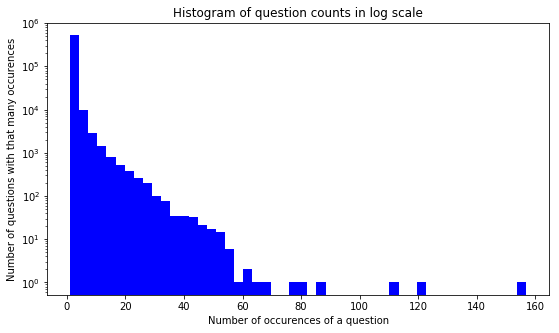

In [7]:
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))

plt.figure(figsize=(9, 5))
plt.hist(qids.value_counts(), bins=50, color='blue')
plt.yscale('log', nonposy='clip')
plt.title('Histogram of question counts in log scale')
plt.xlabel('Number of occurences of a question')
plt.ylabel('Number of questions with that many occurences')
plt.show()

** Majority of the questions have just 1 occurence and very few questions appear multiple times. **

## Section 2. Select Text Modeling Representation

1. Select model representation of text

Consider:
    * Word2vec => Baseline sentence model, capture similarity but without word order
    * paragraph vector => vector representation of the sentence with order
    * CNN => Excellent for sentence classicifcation (Future Consideration)
    * LSTM => State of the Art model with long short term memory (Future considration)

### Cleaning Text

* Remove stop words
* Seperate punctuation from the words

In [8]:
print df_train.loc[1, 'question1']
print utils.preprocess_stop_stem(utils.clean_str(df_train.loc[1, 'question1']), sent=True, punc=False)

What is the story of Kohinoor (Koh-i-Noor) Diamond?
what is the story of kohinoor ( koh-i-noor ) diamond ?


In [23]:
df_train['question1'] = df_train['question1'].apply(utils.preprocess_doc)
df_train['question2'] = df_train['question2'].apply(utils.preprocess_doc)
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india ?,step step guide invest share market ?,0
1,1,3,4,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0
3,3,7,8,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0
4,4,9,10,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0


#### Save cleaned training/test dataframe so it is faster to reload

In [24]:
df_train.to_csv('train_df.csv', encoding='utf-8', index=False)

In [106]:
df_test['question1'] = df_test['question1'].apply(utils.preprocess_doc)
df_test['question2'] = df_test['question2'].apply(utils.preprocess_doc)
df_test.head(5)

,test_id,question1,question2
0,0,surface pro 4 compare ipad pro ?,microsoft choose core m3 core i3 home surface ...
1,1,hair transplant age 24 ? much would cost ?,much cost hair transplant require ?
2,2,best way send money china us ?,send money china ?
3,3,food emulsifiers ?,foods fibre ?
4,4,aberystwyth start reading ?,start reading ?


In [107]:
df_test.to_csv('test_df.csv', encoding='utf-8', index=False)

In [53]:
df_train_clean = pd.read_csv('train_df.csv').fillna("")

In [54]:
df_train_clean.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india ?,step step guide invest share market ?,0
1,1,3,4,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0
3,3,7,8,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0
4,4,9,10,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0


### Select Text Model Represetation

* We can combine questions1 and quesitons2 as a feature to run classification to evaluate the model representation
* We can use the model representation the calculate similariy as a feature to run classificaiton to evaluate the model representation

In [55]:
# Combine the two question into 1 unified question set and create one combined question set.
df_train_clean['questions'] = df_train_clean['question1'] + " " + df_train_clean['question2']
df_train_clean.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,questions
0,0,1,2,step step guide invest share market india ?,step step guide invest share market ?,0,step step guide invest share market india ? st...
1,1,3,4,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0,story kohinoor ( koh-i-noor ) diamond ? would ...
2,2,5,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0,increase speed internet connection using vpn ?...
3,3,7,8,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0,mentally lonely ? solve ? find remainder math ...
4,4,9,10,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0,"one dissolve water quikly sugar , salt , metha..."


In [57]:
# Convert the questions into a list of word tokens
qlist = df_train_clean['questions'].values
qlist_token = [word_tokenize(q) for q in qlist]
train_labels = df_train_clean['is_duplicate'].values
print qlist[:5]
print qlist_token[:5]
print train_labels[:5]

[ 'step step guide invest share market india ? step step guide invest share market ?'
 'story kohinoor ( koh-i-noor ) diamond ? would happen indian government stole kohinoor ( koh-i-noor ) diamond back ?'
 'increase speed internet connection using vpn ? internet speed increased hacking dns ?'
 'mentally lonely ? solve ? find remainder math 23 24 math divided 24 , 23 ?'
 'one dissolve water quikly sugar , salt , methane carbon di oxide ? fish would survive salt water ?']
[['step', 'step', 'guide', 'invest', 'share', 'market', 'india', '?', 'step', 'step', 'guide', 'invest', 'share', 'market', '?'], ['story', 'kohinoor', '(', 'koh-i-noor', ')', 'diamond', '?', 'would', 'happen', 'indian', 'government', 'stole', 'kohinoor', '(', 'koh-i-noor', ')', 'diamond', 'back', '?'], ['increase', 'speed', 'internet', 'connection', 'using', 'vpn', '?', 'internet', 'speed', 'increased', 'hacking', 'dns', '?'], ['mentally', 'lonely', '?', 'solve', '?', 'find', 'remainder', 'math', '23', '24', 'math', 'd

### Word2vec model

* Word2Vec is combining two methods CBOW (continuous bag of words) and skip gram to create a set of contextual probabilities of words together.

In [9]:
## Build a Word2Vec Model
## Import the built-in logging module and configure it so that Word2Vec 
import logging
from gensim.models import word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)

print "Training model..."
w2vmodel = word2vec.Word2Vec(qlist_token, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w2vmodel.init_sims(replace=True)

# save the model for later use. You can load it later using Word2Vec.load()
model_name = "100features_20minwords_10context"
w2vmodel.save(model_name)

2017-12-31 04:47:29,732 : INFO : collecting all words and their counts
2017-12-31 04:47:29,735 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-31 04:47:29,775 : INFO : PROGRESS: at sentence #10000, processed 137739 words, keeping 15419 word types
2017-12-31 04:47:29,814 : INFO : PROGRESS: at sentence #20000, processed 275532 words, keeping 22218 word types
2017-12-31 04:47:29,849 : INFO : PROGRESS: at sentence #30000, processed 413447 words, keeping 27373 word types
2017-12-31 04:47:29,884 : INFO : PROGRESS: at sentence #40000, processed 550543 words, keeping 31508 word types
2017-12-31 04:47:29,919 : INFO : PROGRESS: at sentence #50000, processed 688628 words, keeping 35349 word types


Training model...


2017-12-31 04:47:29,956 : INFO : PROGRESS: at sentence #60000, processed 826259 words, keeping 38653 word types
2017-12-31 04:47:29,991 : INFO : PROGRESS: at sentence #70000, processed 964059 words, keeping 41694 word types
2017-12-31 04:47:30,027 : INFO : PROGRESS: at sentence #80000, processed 1102204 words, keeping 44352 word types
2017-12-31 04:47:30,062 : INFO : PROGRESS: at sentence #90000, processed 1239146 words, keeping 46902 word types
2017-12-31 04:47:30,098 : INFO : PROGRESS: at sentence #100000, processed 1376767 words, keeping 49488 word types
2017-12-31 04:47:30,134 : INFO : PROGRESS: at sentence #110000, processed 1513019 words, keeping 51816 word types
2017-12-31 04:47:30,170 : INFO : PROGRESS: at sentence #120000, processed 1650490 words, keeping 53956 word types
2017-12-31 04:47:30,207 : INFO : PROGRESS: at sentence #130000, processed 1788708 words, keeping 56164 word types
2017-12-31 04:47:30,244 : INFO : PROGRESS: at sentence #140000, processed 1927125 words, keepi

2017-12-31 04:49:38,532 : INFO : PROGRESS: at 1.58% examples, 540 words/s
2017-12-31 04:49:41,080 : INFO : PROGRESS: at 1.63% examples, 545 words/s
2017-12-31 04:49:43,184 : INFO : PROGRESS: at 1.66% examples, 544 words/s
2017-12-31 04:49:46,347 : INFO : PROGRESS: at 1.68% examples, 539 words/s
2017-12-31 04:49:47,551 : INFO : PROGRESS: at 1.71% examples, 542 words/s
2017-12-31 04:49:51,953 : INFO : PROGRESS: at 1.76% examples, 541 words/s
2017-12-31 04:49:53,550 : INFO : PROGRESS: at 1.78% examples, 542 words/s
2017-12-31 04:49:55,541 : INFO : PROGRESS: at 1.81% examples, 542 words/s
2017-12-31 04:49:56,963 : INFO : PROGRESS: at 1.83% examples, 544 words/s
2017-12-31 04:49:59,861 : INFO : PROGRESS: at 1.86% examples, 540 words/s
2017-12-31 04:50:03,243 : INFO : PROGRESS: at 1.90% examples, 543 words/s
2017-12-31 04:50:05,371 : INFO : PROGRESS: at 1.93% examples, 543 words/s
2017-12-31 04:50:06,898 : INFO : PROGRESS: at 1.95% examples, 544 words/s
2017-12-31 04:50:10,607 : INFO : PROGR

2017-12-31 04:54:56,452 : INFO : PROGRESS: at 5.66% examples, 547 words/s
2017-12-31 04:54:57,746 : INFO : PROGRESS: at 5.71% examples, 550 words/s
2017-12-31 04:54:59,541 : INFO : PROGRESS: at 5.74% examples, 550 words/s
2017-12-31 04:55:04,088 : INFO : PROGRESS: at 5.76% examples, 547 words/s
2017-12-31 04:55:05,770 : INFO : PROGRESS: at 5.81% examples, 550 words/s
2017-12-31 04:55:07,026 : INFO : PROGRESS: at 5.84% examples, 551 words/s
2017-12-31 04:55:10,894 : INFO : PROGRESS: at 5.86% examples, 548 words/s
2017-12-31 04:55:12,911 : INFO : PROGRESS: at 5.89% examples, 548 words/s
2017-12-31 04:55:15,121 : INFO : PROGRESS: at 5.94% examples, 550 words/s
2017-12-31 04:55:18,434 : INFO : PROGRESS: at 5.96% examples, 549 words/s
2017-12-31 04:55:20,827 : INFO : PROGRESS: at 5.99% examples, 548 words/s
2017-12-31 04:55:22,860 : INFO : PROGRESS: at 6.04% examples, 551 words/s
2017-12-31 04:55:25,972 : INFO : PROGRESS: at 6.06% examples, 549 words/s
2017-12-31 04:55:28,067 : INFO : PROGR

2017-12-31 04:59:49,341 : INFO : PROGRESS: at 9.50% examples, 552 words/s
2017-12-31 04:59:52,142 : INFO : PROGRESS: at 9.52% examples, 551 words/s
2017-12-31 04:59:54,005 : INFO : PROGRESS: at 9.55% examples, 551 words/s
2017-12-31 04:59:55,700 : INFO : PROGRESS: at 9.57% examples, 552 words/s
2017-12-31 04:59:57,713 : INFO : PROGRESS: at 9.60% examples, 552 words/s
2017-12-31 05:00:00,031 : INFO : PROGRESS: at 9.62% examples, 551 words/s
2017-12-31 05:00:01,344 : INFO : PROGRESS: at 9.65% examples, 552 words/s
2017-12-31 05:00:02,902 : INFO : PROGRESS: at 9.67% examples, 552 words/s
2017-12-31 05:00:04,926 : INFO : PROGRESS: at 9.70% examples, 552 words/s
2017-12-31 05:00:09,188 : INFO : PROGRESS: at 9.72% examples, 550 words/s
2017-12-31 05:00:12,776 : INFO : PROGRESS: at 9.80% examples, 552 words/s
2017-12-31 05:00:16,463 : INFO : PROGRESS: at 9.82% examples, 551 words/s
2017-12-31 05:00:21,007 : INFO : PROGRESS: at 9.89% examples, 552 words/s
2017-12-31 05:00:22,979 : INFO : PROGR

2017-12-31 05:05:05,176 : INFO : PROGRESS: at 13.58% examples, 553 words/s
2017-12-31 05:05:09,821 : INFO : PROGRESS: at 13.61% examples, 552 words/s
2017-12-31 05:05:11,466 : INFO : PROGRESS: at 13.65% examples, 553 words/s
2017-12-31 05:05:13,641 : INFO : PROGRESS: at 13.68% examples, 553 words/s
2017-12-31 05:05:17,786 : INFO : PROGRESS: at 13.70% examples, 551 words/s
2017-12-31 05:05:18,902 : INFO : PROGRESS: at 13.75% examples, 553 words/s
2017-12-31 05:05:21,363 : INFO : PROGRESS: at 13.78% examples, 552 words/s
2017-12-31 05:05:25,218 : INFO : PROGRESS: at 13.80% examples, 551 words/s
2017-12-31 05:05:28,247 : INFO : PROGRESS: at 13.88% examples, 553 words/s
2017-12-31 05:05:32,552 : INFO : PROGRESS: at 13.90% examples, 552 words/s
2017-12-31 05:05:33,664 : INFO : PROGRESS: at 13.95% examples, 553 words/s
2017-12-31 05:05:36,004 : INFO : PROGRESS: at 13.98% examples, 553 words/s
2017-12-31 05:05:39,770 : INFO : PROGRESS: at 14.00% examples, 552 words/s
2017-12-31 05:05:40,958 :

2017-12-31 05:10:05,307 : INFO : PROGRESS: at 17.44% examples, 553 words/s
2017-12-31 05:10:06,427 : INFO : PROGRESS: at 17.49% examples, 554 words/s
2017-12-31 05:10:09,780 : INFO : PROGRESS: at 17.51% examples, 553 words/s
2017-12-31 05:10:12,110 : INFO : PROGRESS: at 17.54% examples, 553 words/s
2017-12-31 05:10:13,345 : INFO : PROGRESS: at 17.56% examples, 553 words/s
2017-12-31 05:10:16,924 : INFO : PROGRESS: at 17.61% examples, 553 words/s
2017-12-31 05:10:20,471 : INFO : PROGRESS: at 17.64% examples, 553 words/s
2017-12-31 05:10:23,304 : INFO : PROGRESS: at 17.71% examples, 554 words/s
2017-12-31 05:10:27,776 : INFO : PROGRESS: at 17.74% examples, 553 words/s
2017-12-31 05:10:28,908 : INFO : PROGRESS: at 17.76% examples, 553 words/s
2017-12-31 05:10:30,512 : INFO : PROGRESS: at 17.81% examples, 554 words/s
2017-12-31 05:10:35,044 : INFO : PROGRESS: at 17.83% examples, 553 words/s
2017-12-31 05:10:36,751 : INFO : PROGRESS: at 17.86% examples, 553 words/s
2017-12-31 05:10:38,946 :

2017-12-31 05:15:25,427 : INFO : PROGRESS: at 21.59% examples, 553 words/s
2017-12-31 05:15:27,981 : INFO : PROGRESS: at 21.64% examples, 554 words/s
2017-12-31 05:15:31,515 : INFO : PROGRESS: at 21.67% examples, 553 words/s
2017-12-31 05:15:33,269 : INFO : PROGRESS: at 21.69% examples, 553 words/s
2017-12-31 05:15:34,457 : INFO : PROGRESS: at 21.72% examples, 554 words/s
2017-12-31 05:15:38,182 : INFO : PROGRESS: at 21.77% examples, 554 words/s
2017-12-31 05:15:39,959 : INFO : PROGRESS: at 21.79% examples, 554 words/s
2017-12-31 05:15:41,590 : INFO : PROGRESS: at 21.82% examples, 554 words/s
2017-12-31 05:15:46,244 : INFO : PROGRESS: at 21.87% examples, 553 words/s
2017-12-31 05:15:48,220 : INFO : PROGRESS: at 21.89% examples, 554 words/s
2017-12-31 05:15:53,642 : INFO : PROGRESS: at 21.97% examples, 554 words/s
2017-12-31 05:15:55,952 : INFO : PROGRESS: at 22.02% examples, 554 words/s
2017-12-31 05:16:00,700 : INFO : PROGRESS: at 22.06% examples, 554 words/s
2017-12-31 05:16:02,072 :

2017-12-31 05:20:22,449 : INFO : PROGRESS: at 25.50% examples, 554 words/s
2017-12-31 05:20:23,817 : INFO : PROGRESS: at 25.55% examples, 555 words/s
2017-12-31 05:20:26,042 : INFO : PROGRESS: at 25.58% examples, 555 words/s
2017-12-31 05:20:30,186 : INFO : PROGRESS: at 25.60% examples, 554 words/s
2017-12-31 05:20:32,870 : INFO : PROGRESS: at 25.68% examples, 555 words/s
2017-12-31 05:20:37,793 : INFO : PROGRESS: at 25.70% examples, 554 words/s
2017-12-31 05:20:40,429 : INFO : PROGRESS: at 25.78% examples, 555 words/s
2017-12-31 05:20:44,351 : INFO : PROGRESS: at 25.80% examples, 555 words/s
2017-12-31 05:20:45,451 : INFO : PROGRESS: at 25.82% examples, 555 words/s
2017-12-31 05:20:48,236 : INFO : PROGRESS: at 25.87% examples, 555 words/s
2017-12-31 05:20:51,846 : INFO : PROGRESS: at 25.90% examples, 555 words/s
2017-12-31 05:20:55,515 : INFO : PROGRESS: at 25.97% examples, 555 words/s
2017-12-31 05:21:00,026 : INFO : PROGRESS: at 26.00% examples, 555 words/s
2017-12-31 05:21:03,105 :

2017-12-31 05:26:05,411 : INFO : PROGRESS: at 29.98% examples, 555 words/s
2017-12-31 05:26:10,589 : INFO : PROGRESS: at 30.01% examples, 554 words/s
2017-12-31 05:26:13,524 : INFO : PROGRESS: at 30.08% examples, 555 words/s
2017-12-31 05:26:18,231 : INFO : PROGRESS: at 30.10% examples, 554 words/s
2017-12-31 05:26:20,186 : INFO : PROGRESS: at 30.15% examples, 555 words/s
2017-12-31 05:26:22,502 : INFO : PROGRESS: at 30.18% examples, 555 words/s
2017-12-31 05:26:25,843 : INFO : PROGRESS: at 30.20% examples, 554 words/s
2017-12-31 05:26:28,152 : INFO : PROGRESS: at 30.25% examples, 555 words/s
2017-12-31 05:26:30,853 : INFO : PROGRESS: at 30.28% examples, 554 words/s
2017-12-31 05:26:33,665 : INFO : PROGRESS: at 30.30% examples, 554 words/s
2017-12-31 05:26:36,453 : INFO : PROGRESS: at 30.35% examples, 554 words/s
2017-12-31 05:26:38,619 : INFO : PROGRESS: at 30.38% examples, 554 words/s
2017-12-31 05:26:40,793 : INFO : PROGRESS: at 30.40% examples, 554 words/s
2017-12-31 05:26:43,045 :

2017-12-31 05:31:16,681 : INFO : PROGRESS: at 34.01% examples, 555 words/s
2017-12-31 05:31:20,294 : INFO : PROGRESS: at 34.04% examples, 555 words/s
2017-12-31 05:31:22,674 : INFO : PROGRESS: at 34.06% examples, 555 words/s
2017-12-31 05:31:26,671 : INFO : PROGRESS: at 34.14% examples, 555 words/s
2017-12-31 05:31:28,897 : INFO : PROGRESS: at 34.16% examples, 555 words/s
2017-12-31 05:31:30,360 : INFO : PROGRESS: at 34.19% examples, 555 words/s
2017-12-31 05:31:33,515 : INFO : PROGRESS: at 34.24% examples, 555 words/s
2017-12-31 05:31:36,856 : INFO : PROGRESS: at 34.26% examples, 555 words/s
2017-12-31 05:31:38,890 : INFO : PROGRESS: at 34.28% examples, 555 words/s
2017-12-31 05:31:41,673 : INFO : PROGRESS: at 34.33% examples, 555 words/s
2017-12-31 05:31:44,921 : INFO : PROGRESS: at 34.36% examples, 555 words/s
2017-12-31 05:31:45,927 : INFO : PROGRESS: at 34.38% examples, 555 words/s
2017-12-31 05:31:49,625 : INFO : PROGRESS: at 34.43% examples, 555 words/s
2017-12-31 05:31:52,762 :

2017-12-31 05:36:00,657 : INFO : PROGRESS: at 37.67% examples, 555 words/s
2017-12-31 05:36:02,118 : INFO : PROGRESS: at 37.70% examples, 555 words/s
2017-12-31 05:36:04,203 : INFO : PROGRESS: at 37.72% examples, 555 words/s
2017-12-31 05:36:05,306 : INFO : PROGRESS: at 37.75% examples, 556 words/s
2017-12-31 05:36:07,915 : INFO : PROGRESS: at 37.77% examples, 555 words/s
2017-12-31 05:36:10,241 : INFO : PROGRESS: at 37.80% examples, 555 words/s
2017-12-31 05:36:12,124 : INFO : PROGRESS: at 37.85% examples, 556 words/s
2017-12-31 05:36:16,396 : INFO : PROGRESS: at 37.87% examples, 555 words/s
2017-12-31 05:36:18,204 : INFO : PROGRESS: at 37.92% examples, 556 words/s
2017-12-31 05:36:20,623 : INFO : PROGRESS: at 37.95% examples, 556 words/s
2017-12-31 05:36:25,008 : INFO : PROGRESS: at 37.97% examples, 555 words/s
2017-12-31 05:36:26,959 : INFO : PROGRESS: at 38.04% examples, 556 words/s
2017-12-31 05:36:33,042 : INFO : PROGRESS: at 38.07% examples, 555 words/s
2017-12-31 05:36:34,280 :

2017-12-31 05:40:55,071 : INFO : PROGRESS: at 41.46% examples, 555 words/s
2017-12-31 05:40:56,257 : INFO : PROGRESS: at 41.51% examples, 556 words/s
2017-12-31 05:40:57,616 : INFO : PROGRESS: at 41.53% examples, 556 words/s
2017-12-31 05:41:02,858 : INFO : PROGRESS: at 41.56% examples, 555 words/s
2017-12-31 05:41:05,020 : INFO : PROGRESS: at 41.63% examples, 556 words/s
2017-12-31 05:41:10,268 : INFO : PROGRESS: at 41.66% examples, 555 words/s
2017-12-31 05:41:17,127 : INFO : PROGRESS: at 41.75% examples, 555 words/s
2017-12-31 05:41:18,267 : INFO : PROGRESS: at 41.78% examples, 556 words/s
2017-12-31 05:41:23,754 : INFO : PROGRESS: at 41.85% examples, 556 words/s
2017-12-31 05:41:25,166 : INFO : PROGRESS: at 41.88% examples, 556 words/s
2017-12-31 05:41:26,479 : INFO : PROGRESS: at 41.93% examples, 556 words/s
2017-12-31 05:41:30,517 : INFO : PROGRESS: at 41.95% examples, 556 words/s
2017-12-31 05:41:33,765 : INFO : PROGRESS: at 41.98% examples, 555 words/s
2017-12-31 05:41:37,936 :

2017-12-31 05:45:50,620 : INFO : PROGRESS: at 45.27% examples, 555 words/s
2017-12-31 05:45:51,906 : INFO : PROGRESS: at 45.29% examples, 556 words/s
2017-12-31 05:45:53,676 : INFO : PROGRESS: at 45.32% examples, 556 words/s
2017-12-31 05:45:55,235 : INFO : PROGRESS: at 45.34% examples, 556 words/s
2017-12-31 05:45:57,750 : INFO : PROGRESS: at 45.37% examples, 556 words/s
2017-12-31 05:46:00,829 : INFO : PROGRESS: at 45.39% examples, 555 words/s
2017-12-31 05:46:02,351 : INFO : PROGRESS: at 45.44% examples, 556 words/s
2017-12-31 05:46:04,586 : INFO : PROGRESS: at 45.47% examples, 556 words/s
2017-12-31 05:46:07,616 : INFO : PROGRESS: at 45.49% examples, 555 words/s
2017-12-31 05:46:09,203 : INFO : PROGRESS: at 45.51% examples, 556 words/s
2017-12-31 05:46:10,575 : INFO : PROGRESS: at 45.54% examples, 556 words/s
2017-12-31 05:46:11,673 : INFO : PROGRESS: at 45.56% examples, 556 words/s
2017-12-31 05:46:15,321 : INFO : PROGRESS: at 45.59% examples, 555 words/s
2017-12-31 05:46:17,116 :

2017-12-31 05:51:07,907 : INFO : PROGRESS: at 49.40% examples, 556 words/s
2017-12-31 05:51:09,110 : INFO : PROGRESS: at 49.45% examples, 556 words/s
2017-12-31 05:51:11,503 : INFO : PROGRESS: at 49.47% examples, 556 words/s
2017-12-31 05:51:15,823 : INFO : PROGRESS: at 49.50% examples, 555 words/s
2017-12-31 05:51:17,505 : INFO : PROGRESS: at 49.55% examples, 556 words/s
2017-12-31 05:51:20,542 : INFO : PROGRESS: at 49.57% examples, 556 words/s
2017-12-31 05:51:23,581 : INFO : PROGRESS: at 49.60% examples, 555 words/s
2017-12-31 05:51:24,980 : INFO : PROGRESS: at 49.65% examples, 556 words/s
2017-12-31 05:51:28,047 : INFO : PROGRESS: at 49.67% examples, 556 words/s
2017-12-31 05:51:31,733 : INFO : PROGRESS: at 49.70% examples, 555 words/s
2017-12-31 05:51:35,131 : INFO : PROGRESS: at 49.77% examples, 556 words/s
2017-12-31 05:51:39,389 : INFO : PROGRESS: at 49.79% examples, 555 words/s
2017-12-31 05:51:40,466 : INFO : PROGRESS: at 49.84% examples, 556 words/s
2017-12-31 05:51:42,853 :

2017-12-31 05:56:21,270 : INFO : PROGRESS: at 53.46% examples, 555 words/s
2017-12-31 05:56:23,749 : INFO : PROGRESS: at 53.48% examples, 555 words/s
2017-12-31 05:56:26,562 : INFO : PROGRESS: at 53.50% examples, 555 words/s
2017-12-31 05:56:28,932 : INFO : PROGRESS: at 53.53% examples, 555 words/s
2017-12-31 05:56:31,600 : INFO : PROGRESS: at 53.58% examples, 555 words/s
2017-12-31 05:56:34,321 : INFO : PROGRESS: at 53.60% examples, 555 words/s
2017-12-31 05:56:36,089 : INFO : PROGRESS: at 53.63% examples, 555 words/s
2017-12-31 05:56:39,668 : INFO : PROGRESS: at 53.68% examples, 555 words/s
2017-12-31 05:56:43,154 : INFO : PROGRESS: at 53.70% examples, 555 words/s
2017-12-31 05:56:45,361 : INFO : PROGRESS: at 53.75% examples, 555 words/s
2017-12-31 05:56:46,736 : INFO : PROGRESS: at 53.78% examples, 555 words/s
2017-12-31 05:56:50,435 : INFO : PROGRESS: at 53.80% examples, 555 words/s
2017-12-31 05:56:53,498 : INFO : PROGRESS: at 53.85% examples, 555 words/s
2017-12-31 05:56:55,550 :

2017-12-31 06:00:52,114 : INFO : PROGRESS: at 56.97% examples, 555 words/s
2017-12-31 06:00:53,818 : INFO : PROGRESS: at 57.02% examples, 556 words/s
2017-12-31 06:00:58,167 : INFO : PROGRESS: at 57.04% examples, 555 words/s
2017-12-31 06:01:00,298 : INFO : PROGRESS: at 57.07% examples, 555 words/s
2017-12-31 06:01:01,554 : INFO : PROGRESS: at 57.12% examples, 556 words/s
2017-12-31 06:01:06,898 : INFO : PROGRESS: at 57.14% examples, 555 words/s
2017-12-31 06:01:09,730 : INFO : PROGRESS: at 57.19% examples, 555 words/s
2017-12-31 06:01:13,510 : INFO : PROGRESS: at 57.24% examples, 555 words/s
2017-12-31 06:01:17,063 : INFO : PROGRESS: at 57.29% examples, 555 words/s
2017-12-31 06:01:20,318 : INFO : PROGRESS: at 57.34% examples, 555 words/s
2017-12-31 06:01:21,923 : INFO : PROGRESS: at 57.36% examples, 555 words/s
2017-12-31 06:01:23,631 : INFO : PROGRESS: at 57.39% examples, 555 words/s
2017-12-31 06:01:26,161 : INFO : PROGRESS: at 57.41% examples, 555 words/s
2017-12-31 06:01:28,424 :

2017-12-31 06:05:33,680 : INFO : PROGRESS: at 60.60% examples, 555 words/s
2017-12-31 06:05:38,974 : INFO : PROGRESS: at 60.65% examples, 555 words/s
2017-12-31 06:05:40,038 : INFO : PROGRESS: at 60.70% examples, 555 words/s
2017-12-31 06:05:45,329 : INFO : PROGRESS: at 60.73% examples, 555 words/s
2017-12-31 06:05:46,731 : INFO : PROGRESS: at 60.75% examples, 555 words/s
2017-12-31 06:05:50,039 : INFO : PROGRESS: at 60.80% examples, 555 words/s
2017-12-31 06:05:53,174 : INFO : PROGRESS: at 60.83% examples, 555 words/s
2017-12-31 06:05:55,050 : INFO : PROGRESS: at 60.88% examples, 555 words/s
2017-12-31 06:05:58,544 : INFO : PROGRESS: at 60.90% examples, 555 words/s
2017-12-31 06:06:00,070 : INFO : PROGRESS: at 60.93% examples, 555 words/s
2017-12-31 06:06:02,336 : INFO : PROGRESS: at 60.95% examples, 555 words/s
2017-12-31 06:06:05,765 : INFO : PROGRESS: at 61.00% examples, 555 words/s
2017-12-31 06:06:07,072 : INFO : PROGRESS: at 61.02% examples, 555 words/s
2017-12-31 06:06:09,873 :

2017-12-31 06:10:48,118 : INFO : PROGRESS: at 64.64% examples, 555 words/s
2017-12-31 06:10:49,814 : INFO : PROGRESS: at 64.66% examples, 555 words/s
2017-12-31 06:10:52,195 : INFO : PROGRESS: at 64.69% examples, 555 words/s
2017-12-31 06:10:54,378 : INFO : PROGRESS: at 64.71% examples, 555 words/s
2017-12-31 06:10:55,424 : INFO : PROGRESS: at 64.74% examples, 555 words/s
2017-12-31 06:10:57,707 : INFO : PROGRESS: at 64.76% examples, 555 words/s
2017-12-31 06:10:59,708 : INFO : PROGRESS: at 64.78% examples, 555 words/s
2017-12-31 06:11:01,158 : INFO : PROGRESS: at 64.81% examples, 555 words/s
2017-12-31 06:11:02,361 : INFO : PROGRESS: at 64.83% examples, 555 words/s
2017-12-31 06:11:05,517 : INFO : PROGRESS: at 64.86% examples, 555 words/s
2017-12-31 06:11:07,328 : INFO : PROGRESS: at 64.88% examples, 555 words/s
2017-12-31 06:11:09,603 : INFO : PROGRESS: at 64.93% examples, 555 words/s
2017-12-31 06:11:12,737 : INFO : PROGRESS: at 64.96% examples, 555 words/s
2017-12-31 06:11:14,419 :

2017-12-31 06:15:53,112 : INFO : PROGRESS: at 68.54% examples, 555 words/s
2017-12-31 06:15:58,008 : INFO : PROGRESS: at 68.59% examples, 555 words/s
2017-12-31 06:15:59,711 : INFO : PROGRESS: at 68.62% examples, 555 words/s
2017-12-31 06:16:01,031 : INFO : PROGRESS: at 68.67% examples, 555 words/s
2017-12-31 06:16:06,014 : INFO : PROGRESS: at 68.69% examples, 555 words/s
2017-12-31 06:16:10,004 : INFO : PROGRESS: at 68.77% examples, 555 words/s
2017-12-31 06:16:12,842 : INFO : PROGRESS: at 68.79% examples, 555 words/s
2017-12-31 06:16:14,605 : INFO : PROGRESS: at 68.82% examples, 555 words/s
2017-12-31 06:16:17,745 : INFO : PROGRESS: at 68.87% examples, 555 words/s
2017-12-31 06:16:20,780 : INFO : PROGRESS: at 68.89% examples, 555 words/s
2017-12-31 06:16:22,549 : INFO : PROGRESS: at 68.94% examples, 555 words/s
2017-12-31 06:16:24,678 : INFO : PROGRESS: at 68.97% examples, 555 words/s
2017-12-31 06:16:28,197 : INFO : PROGRESS: at 68.99% examples, 555 words/s
2017-12-31 06:16:29,783 :

2017-12-31 06:20:31,993 : INFO : PROGRESS: at 72.13% examples, 555 words/s
2017-12-31 06:20:33,189 : INFO : PROGRESS: at 72.16% examples, 555 words/s
2017-12-31 06:20:35,063 : INFO : PROGRESS: at 72.18% examples, 555 words/s
2017-12-31 06:20:36,439 : INFO : PROGRESS: at 72.21% examples, 555 words/s
2017-12-31 06:20:38,201 : INFO : PROGRESS: at 72.23% examples, 555 words/s
2017-12-31 06:20:40,615 : INFO : PROGRESS: at 72.25% examples, 555 words/s
2017-12-31 06:20:43,722 : INFO : PROGRESS: at 72.30% examples, 555 words/s
2017-12-31 06:20:45,245 : INFO : PROGRESS: at 72.33% examples, 555 words/s
2017-12-31 06:20:47,475 : INFO : PROGRESS: at 72.35% examples, 555 words/s
2017-12-31 06:20:51,125 : INFO : PROGRESS: at 72.40% examples, 555 words/s
2017-12-31 06:20:53,075 : INFO : PROGRESS: at 72.43% examples, 555 words/s
2017-12-31 06:20:55,468 : INFO : PROGRESS: at 72.45% examples, 555 words/s
2017-12-31 06:20:57,791 : INFO : PROGRESS: at 72.50% examples, 555 words/s
2017-12-31 06:21:00,890 :

2017-12-31 06:25:15,492 : INFO : PROGRESS: at 75.82% examples, 555 words/s
2017-12-31 06:25:17,245 : INFO : PROGRESS: at 75.87% examples, 555 words/s
2017-12-31 06:25:19,206 : INFO : PROGRESS: at 75.89% examples, 555 words/s
2017-12-31 06:25:22,087 : INFO : PROGRESS: at 75.92% examples, 555 words/s
2017-12-31 06:25:23,230 : INFO : PROGRESS: at 75.94% examples, 555 words/s
2017-12-31 06:25:25,017 : INFO : PROGRESS: at 75.97% examples, 555 words/s
2017-12-31 06:25:27,548 : INFO : PROGRESS: at 75.99% examples, 555 words/s
2017-12-31 06:25:29,323 : INFO : PROGRESS: at 76.01% examples, 555 words/s
2017-12-31 06:25:31,269 : INFO : PROGRESS: at 76.04% examples, 555 words/s
2017-12-31 06:25:32,859 : INFO : PROGRESS: at 76.06% examples, 555 words/s
2017-12-31 06:25:35,662 : INFO : PROGRESS: at 76.09% examples, 555 words/s
2017-12-31 06:25:39,704 : INFO : PROGRESS: at 76.14% examples, 555 words/s
2017-12-31 06:25:43,210 : INFO : PROGRESS: at 76.19% examples, 555 words/s
2017-12-31 06:25:46,288 :

2017-12-31 06:30:16,735 : INFO : PROGRESS: at 79.77% examples, 555 words/s
2017-12-31 06:30:19,735 : INFO : PROGRESS: at 79.80% examples, 555 words/s
2017-12-31 06:30:21,197 : INFO : PROGRESS: at 79.82% examples, 555 words/s
2017-12-31 06:30:24,799 : INFO : PROGRESS: at 79.87% examples, 555 words/s
2017-12-31 06:30:27,356 : INFO : PROGRESS: at 79.90% examples, 555 words/s
2017-12-31 06:30:29,520 : INFO : PROGRESS: at 79.92% examples, 555 words/s
2017-12-31 06:30:32,997 : INFO : PROGRESS: at 79.97% examples, 555 words/s
2017-12-31 06:30:34,162 : INFO : PROGRESS: at 80.00% examples, 555 words/s
2017-12-31 06:30:36,293 : INFO : PROGRESS: at 80.02% examples, 555 words/s
2017-12-31 06:30:40,609 : INFO : PROGRESS: at 80.07% examples, 555 words/s
2017-12-31 06:30:42,137 : INFO : PROGRESS: at 80.10% examples, 555 words/s
2017-12-31 06:30:43,943 : INFO : PROGRESS: at 80.12% examples, 555 words/s
2017-12-31 06:30:48,733 : INFO : PROGRESS: at 80.17% examples, 555 words/s
2017-12-31 06:30:51,316 :

2017-12-31 06:35:16,740 : INFO : PROGRESS: at 83.63% examples, 555 words/s
2017-12-31 06:35:17,884 : INFO : PROGRESS: at 83.66% examples, 555 words/s
2017-12-31 06:35:22,163 : INFO : PROGRESS: at 83.68% examples, 555 words/s
2017-12-31 06:35:24,979 : INFO : PROGRESS: at 83.73% examples, 555 words/s
2017-12-31 06:35:28,786 : INFO : PROGRESS: at 83.78% examples, 555 words/s
2017-12-31 06:35:31,094 : INFO : PROGRESS: at 83.81% examples, 555 words/s
2017-12-31 06:35:33,411 : INFO : PROGRESS: at 83.83% examples, 555 words/s
2017-12-31 06:35:37,651 : INFO : PROGRESS: at 83.88% examples, 555 words/s
2017-12-31 06:35:38,772 : INFO : PROGRESS: at 83.91% examples, 555 words/s
2017-12-31 06:35:41,194 : INFO : PROGRESS: at 83.93% examples, 555 words/s
2017-12-31 06:35:44,649 : INFO : PROGRESS: at 83.98% examples, 555 words/s
2017-12-31 06:35:45,734 : INFO : PROGRESS: at 84.00% examples, 555 words/s
2017-12-31 06:35:48,734 : INFO : PROGRESS: at 84.03% examples, 555 words/s
2017-12-31 06:35:52,819 :

2017-12-31 06:40:23,216 : INFO : PROGRESS: at 87.54% examples, 555 words/s
2017-12-31 06:40:24,368 : INFO : PROGRESS: at 87.59% examples, 555 words/s
2017-12-31 06:40:30,276 : INFO : PROGRESS: at 87.64% examples, 555 words/s
2017-12-31 06:40:32,182 : INFO : PROGRESS: at 87.69% examples, 555 words/s
2017-12-31 06:40:33,728 : INFO : PROGRESS: at 87.72% examples, 555 words/s
2017-12-31 06:40:38,403 : INFO : PROGRESS: at 87.74% examples, 555 words/s
2017-12-31 06:40:40,677 : INFO : PROGRESS: at 87.79% examples, 555 words/s
2017-12-31 06:40:45,577 : INFO : PROGRESS: at 87.84% examples, 555 words/s
2017-12-31 06:40:47,373 : INFO : PROGRESS: at 87.89% examples, 555 words/s
2017-12-31 06:40:49,352 : INFO : PROGRESS: at 87.91% examples, 555 words/s
2017-12-31 06:40:53,261 : INFO : PROGRESS: at 87.94% examples, 555 words/s
2017-12-31 06:40:55,488 : INFO : PROGRESS: at 87.99% examples, 555 words/s
2017-12-31 06:41:01,020 : INFO : PROGRESS: at 88.04% examples, 555 words/s
2017-12-31 06:41:02,915 :

2017-12-31 06:45:31,156 : INFO : PROGRESS: at 91.60% examples, 555 words/s
2017-12-31 06:45:33,691 : INFO : PROGRESS: at 91.62% examples, 555 words/s
2017-12-31 06:45:34,723 : INFO : PROGRESS: at 91.65% examples, 555 words/s
2017-12-31 06:45:35,839 : INFO : PROGRESS: at 91.67% examples, 555 words/s
2017-12-31 06:45:38,719 : INFO : PROGRESS: at 91.70% examples, 555 words/s
2017-12-31 06:45:42,311 : INFO : PROGRESS: at 91.72% examples, 555 words/s
2017-12-31 06:45:46,062 : INFO : PROGRESS: at 91.80% examples, 555 words/s
2017-12-31 06:45:49,253 : INFO : PROGRESS: at 91.82% examples, 555 words/s
2017-12-31 06:45:50,354 : INFO : PROGRESS: at 91.85% examples, 555 words/s
2017-12-31 06:45:53,257 : INFO : PROGRESS: at 91.90% examples, 555 words/s
2017-12-31 06:45:58,564 : INFO : PROGRESS: at 91.92% examples, 555 words/s
2017-12-31 06:46:00,508 : INFO : PROGRESS: at 91.99% examples, 555 words/s
2017-12-31 06:46:06,180 : INFO : PROGRESS: at 92.02% examples, 555 words/s
2017-12-31 06:46:07,272 :

2017-12-31 06:50:10,576 : INFO : PROGRESS: at 95.14% examples, 555 words/s
2017-12-31 06:50:12,282 : INFO : PROGRESS: at 95.16% examples, 555 words/s
2017-12-31 06:50:13,353 : INFO : PROGRESS: at 95.19% examples, 555 words/s
2017-12-31 06:50:17,336 : INFO : PROGRESS: at 95.24% examples, 555 words/s
2017-12-31 06:50:19,489 : INFO : PROGRESS: at 95.26% examples, 555 words/s
2017-12-31 06:50:21,387 : INFO : PROGRESS: at 95.28% examples, 555 words/s
2017-12-31 06:50:26,196 : INFO : PROGRESS: at 95.33% examples, 555 words/s
2017-12-31 06:50:30,040 : INFO : PROGRESS: at 95.38% examples, 555 words/s
2017-12-31 06:50:33,674 : INFO : PROGRESS: at 95.43% examples, 555 words/s
2017-12-31 06:50:35,910 : INFO : PROGRESS: at 95.46% examples, 555 words/s
2017-12-31 06:50:37,187 : INFO : PROGRESS: at 95.48% examples, 555 words/s
2017-12-31 06:50:41,225 : INFO : PROGRESS: at 95.53% examples, 555 words/s
2017-12-31 06:50:43,490 : INFO : PROGRESS: at 95.56% examples, 555 words/s
2017-12-31 06:50:45,928 :

2017-12-31 06:55:18,281 : INFO : PROGRESS: at 99.07% examples, 555 words/s
2017-12-31 06:55:22,721 : INFO : PROGRESS: at 99.09% examples, 554 words/s
2017-12-31 06:55:24,906 : INFO : PROGRESS: at 99.12% examples, 554 words/s
2017-12-31 06:55:26,099 : INFO : PROGRESS: at 99.17% examples, 555 words/s
2017-12-31 06:55:30,760 : INFO : PROGRESS: at 99.19% examples, 554 words/s
2017-12-31 06:55:32,745 : INFO : PROGRESS: at 99.22% examples, 554 words/s
2017-12-31 06:55:34,465 : INFO : PROGRESS: at 99.27% examples, 555 words/s
2017-12-31 06:55:37,853 : INFO : PROGRESS: at 99.29% examples, 554 words/s
2017-12-31 06:55:40,999 : INFO : PROGRESS: at 99.32% examples, 554 words/s
2017-12-31 06:55:42,769 : INFO : PROGRESS: at 99.37% examples, 554 words/s
2017-12-31 06:55:45,135 : INFO : PROGRESS: at 99.39% examples, 554 words/s
2017-12-31 06:55:47,472 : INFO : PROGRESS: at 99.42% examples, 554 words/s
2017-12-31 06:55:49,712 : INFO : PROGRESS: at 99.46% examples, 555 words/s
2017-12-31 06:55:51,821 :

In [10]:
w2v = dict(zip(w2vmodel.index2word, w2vmodel.syn0))
print "Sample word to vector representation for word computer", w2v['computer']

Sample word to vector representation for word computer [  1.85314119e-02  -5.02025075e-02  -1.33813089e-02  -5.09452187e-02
  -2.21154794e-01   9.64184552e-02  -1.24967776e-01   8.67541805e-02
  -2.04047814e-01  -7.91265070e-02   3.65674868e-02  -9.63807758e-03
  -1.09489508e-01   3.01285312e-02  -4.20199372e-02   1.23462696e-02
  -7.57567734e-02   9.71459299e-02  -1.48858219e-01   1.75827235e-01
  -1.53687805e-01  -1.09506235e-01  -6.97505102e-02  -4.01635580e-02
  -2.20579714e-01   2.25819610e-02   7.37174228e-02  -1.51217788e-01
  -1.66915432e-01  -1.61941260e-01  -1.57146424e-01   5.90728000e-02
  -1.37609273e-01  -3.13317887e-02  -5.52040301e-02   1.33059412e-01
  -6.56671971e-02   1.90940499e-01  -9.72908083e-03  -4.17623185e-02
  -1.08748069e-02  -7.91625381e-02  -1.73807353e-01   4.17500809e-02
  -7.59434924e-02  -2.46464852e-02   4.51667747e-03  -7.53790811e-02
  -3.52359414e-02  -1.90751012e-02  -1.11883707e-01   1.12692259e-01
   3.53231095e-02   1.94360316e-01   3.15093203e

#### Check saved model

In [66]:
word2vec_model = word2vec.Word2Vec.load('100features_20minwords_10context')

In [67]:
w2v = dict(zip(word2vec_model.index2word, word2vec_model.syn0))
print "Sample word to vector representation for word computer", w2v['computer']

Sample word to vector representation for word computer [  1.85314119e-02  -5.02025075e-02  -1.33813089e-02  -5.09452187e-02
  -2.21154794e-01   9.64184552e-02  -1.24967776e-01   8.67541805e-02
  -2.04047814e-01  -7.91265070e-02   3.65674868e-02  -9.63807758e-03
  -1.09489508e-01   3.01285312e-02  -4.20199372e-02   1.23462696e-02
  -7.57567734e-02   9.71459299e-02  -1.48858219e-01   1.75827235e-01
  -1.53687805e-01  -1.09506235e-01  -6.97505102e-02  -4.01635580e-02
  -2.20579714e-01   2.25819610e-02   7.37174228e-02  -1.51217788e-01
  -1.66915432e-01  -1.61941260e-01  -1.57146424e-01   5.90728000e-02
  -1.37609273e-01  -3.13317887e-02  -5.52040301e-02   1.33059412e-01
  -6.56671971e-02   1.90940499e-01  -9.72908083e-03  -4.17623185e-02
  -1.08748069e-02  -7.91625381e-02  -1.73807353e-01   4.17500809e-02
  -7.59434924e-02  -2.46464852e-02   4.51667747e-03  -7.53790811e-02
  -3.52359414e-02  -1.90751012e-02  -1.11883707e-01   1.12692259e-01
   3.53231095e-02   1.94360316e-01   3.15093203e

In [68]:
# Compute mean word2Vec for each word in a given sentence
def compute_sentence_vec(X, wordvector):
        dim = len(wordvector.itervalues().next())
        return np.array([
            np.mean([wordvector[w] for w in words if w in wordvector]
                    or [np.zeros(dim)], axis=0)
            for words in X
        ])

In [69]:
train_labels = df_train_clean['is_duplicate'].values
mean_sentence_vector = compute_sentence_vec(qlist_token, w2v)
print "Length of Mean Sentence Vector ", len(mean_sentence_vector)
print "Length of training labels ", len(train_labels)

Length of Mean Sentence Vector  404290
Length of training labels  404290


In [18]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(mean_sentence_vector, train_labels, test_size=0.25, random_state=3)

#### Try Random Forrest Model

Well make a simple Random Forest Model to test the first feature.

In [20]:
RF = sklearn.ensemble.RandomForestClassifier(n_estimators=20, criterion = 'entropy', max_features = None)

RF.fit(X_train, y_train)
y_preds = RF.predict(X_test)

print metrics.classification_report(y_test, y_preds)
print metrics.accuracy_score(y_test, y_preds)

             precision    recall  f1-score   support

          0       0.79      0.91      0.84     63673
          1       0.79      0.58      0.67     37393

avg / total       0.79      0.79      0.78    101066

0.787564561772


Using training set along, the result looks promising

### Paragraph Vector Model

In [9]:
#Helper function to convert newsgroup corpus into paragraph2Vec formats
from gensim.models import doc2vec
def convert_reviews(docs, split):
    #global doc_count
    tagged_documents = []
    
    for i,v in enumerate(docs):
        label = '%s_%s'%(split, i)
        tagged_documents.append(doc2vec.LabeledSentence(v, [label]))
    
    return tagged_documents

In [10]:
train_labels = df_train_clean['is_duplicate'].values
print "train labels:", len(train_labels)
print "train_data:", len(qlist_token)

train labels: 404263
train_data: 404263


In [44]:
# Split for test set
train_docs, train_labels, test_docs, test_labels = utils.get_train_test_docs(qlist_token, 
                                                                             train_labels, 
                                                                             split = 0.8, 
                                                                             shuffle = True)

Loaded 404263 docs (5.5737e+06 tokens)
Training set: 323410 docs (4460679 tokens)
Test set: 80853 docs (1113018 tokens)


In [46]:
## Convert to paragraph2vec library input format
train_docs = convert_reviews(train_docs, 'train')
test_docs = convert_reviews(test_docs, 'test')

## We combine all data to build the paragraph vector model
all_docs = []
all_docs.extend(train_docs)
all_docs.extend(test_docs)
doc_list = all_docs[:]  # for reshuffling per pass

print '{} docs: {} train, {} test'.format(len(doc_list), len(train_docs), len(test_docs))

404263 docs: 323410 train, 80853 test


In [47]:
train_docs[2]

TaggedDocument(words=['johnny', 'carson', "'s", 'sons', ',', 'christopher', '(', 'kit', ')', 'cory', 'carson', ',', 'today', '?', 'marilyn', 'monroe', 'ever', 'guest', 'johnny', 'carson', "'s", 'show', ',', 'late', 'night', 'tv', 'program', '?'], tags=['train_2'])

#### Paragraph vect model with feature size of 100

In [34]:
# dm = 0 use distributed bag of words, dm=1 distributed memory
dm_model = Doc2Vec(dm=1, dm_mean=1, sample=1e-3, size=100, window=10, 
                   negative=5, hs=0, min_count=20, workers=10, max_vocab_size = 20000)
dm_model.build_vocab(all_docs)

In [36]:
import progressbar
from random import shuffle
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

alpha, min_alpha, passes = (0.05, 0.01, 5)
alpha_delta = (alpha - min_alpha) / passes
bar = progressbar.ProgressBar()

#for epoch in bar(range(passes)):
shuffle(doc_list)
#dm_model.alpha, dm_model.min_alpha = alpha, alpha
dm_model.train(doc_list, total_examples=len(doc_list))
#alpha -= alpha_delta

#dm_model.init_sims(replace=True)   
model_name = "100features_20000vocab_p2v"
dm_model.save(model_name)

2018-01-01 22:26:26,170 : INFO : training model with 10 workers on 8778 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 and negative=5
2018-01-01 22:26:34,258 : INFO : PROGRESS: at 0.02% examples, 118 words/s
2018-01-01 22:26:35,270 : INFO : PROGRESS: at 0.17% examples, 760 words/s
2018-01-01 22:26:43,080 : INFO : PROGRESS: at 0.27% examples, 656 words/s
2018-01-01 22:26:44,164 : INFO : PROGRESS: at 0.45% examples, 1016 words/s
2018-01-01 22:26:46,024 : INFO : PROGRESS: at 0.49% examples, 1032 words/s
2018-01-01 22:26:51,468 : INFO : PROGRESS: at 0.52% examples, 847 words/s
2018-01-01 22:26:52,473 : INFO : PROGRESS: at 0.57% examples, 892 words/s
2018-01-01 22:26:53,533 : INFO : PROGRESS: at 0.69% examples, 1043 words/s
2018-01-01 22:26:55,359 : INFO : PROGRESS: at 0.74% examples, 1051 words/s
2018-01-01 22:27:00,527 : INFO : PROGRESS: at 0.77% examples, 919 words/s
2018-01-01 22:27:01,612 : INFO : PROGRESS: at 0.84% examples, 978 words/s
2018-01-01 22:27:03,407 : INFO : PROG

2018-01-01 22:30:35,433 : INFO : PROGRESS: at 6.88% examples, 1125 words/s
2018-01-01 22:30:38,945 : INFO : PROGRESS: at 6.90% examples, 1114 words/s
2018-01-01 22:30:40,244 : INFO : PROGRESS: at 6.95% examples, 1116 words/s
2018-01-01 22:30:41,426 : INFO : PROGRESS: at 6.98% examples, 1114 words/s
2018-01-01 22:30:42,834 : INFO : PROGRESS: at 7.07% examples, 1123 words/s
2018-01-01 22:30:44,025 : INFO : PROGRESS: at 7.12% examples, 1126 words/s
2018-01-01 22:30:47,429 : INFO : PROGRESS: at 7.15% examples, 1115 words/s
2018-01-01 22:30:48,700 : INFO : PROGRESS: at 7.17% examples, 1113 words/s
2018-01-01 22:30:50,155 : INFO : PROGRESS: at 7.22% examples, 1115 words/s
2018-01-01 22:30:51,783 : INFO : PROGRESS: at 7.30% examples, 1119 words/s
2018-01-01 22:30:52,856 : INFO : PROGRESS: at 7.37% examples, 1126 words/s
2018-01-01 22:30:56,274 : INFO : PROGRESS: at 7.40% examples, 1116 words/s
2018-01-01 22:30:58,075 : INFO : PROGRESS: at 7.42% examples, 1112 words/s
2018-01-01 22:30:59,160 :

2018-01-01 22:34:18,964 : INFO : PROGRESS: at 13.01% examples, 1124 words/s
2018-01-01 22:34:22,415 : INFO : PROGRESS: at 13.04% examples, 1119 words/s
2018-01-01 22:34:24,572 : INFO : PROGRESS: at 13.06% examples, 1116 words/s
2018-01-01 22:34:25,898 : INFO : PROGRESS: at 13.16% examples, 1121 words/s
2018-01-01 22:34:26,974 : INFO : PROGRESS: at 13.21% examples, 1123 words/s
2018-01-01 22:34:31,029 : INFO : PROGRESS: at 13.28% examples, 1119 words/s
2018-01-01 22:34:34,281 : INFO : PROGRESS: at 13.31% examples, 1114 words/s
2018-01-01 22:34:35,385 : INFO : PROGRESS: at 13.41% examples, 1120 words/s
2018-01-01 22:34:37,140 : INFO : PROGRESS: at 13.48% examples, 1122 words/s
2018-01-01 22:34:40,972 : INFO : PROGRESS: at 13.53% examples, 1118 words/s
2018-01-01 22:34:43,632 : INFO : PROGRESS: at 13.56% examples, 1114 words/s
2018-01-01 22:34:45,021 : INFO : PROGRESS: at 13.65% examples, 1119 words/s
2018-01-01 22:34:46,073 : INFO : PROGRESS: at 13.70% examples, 1121 words/s
2018-01-01 2

2018-01-01 22:37:35,663 : INFO : PROGRESS: at 18.40% examples, 1125 words/s
2018-01-01 22:37:37,963 : INFO : PROGRESS: at 18.48% examples, 1126 words/s
2018-01-01 22:37:40,231 : INFO : PROGRESS: at 18.53% examples, 1125 words/s
2018-01-01 22:37:41,291 : INFO : PROGRESS: at 18.55% examples, 1125 words/s
2018-01-01 22:37:42,891 : INFO : PROGRESS: at 18.60% examples, 1126 words/s
2018-01-01 22:37:44,428 : INFO : PROGRESS: at 18.68% examples, 1127 words/s
2018-01-01 22:37:46,399 : INFO : PROGRESS: at 18.73% examples, 1127 words/s
2018-01-01 22:37:47,483 : INFO : PROGRESS: at 18.75% examples, 1127 words/s
2018-01-01 22:37:48,716 : INFO : PROGRESS: at 18.77% examples, 1126 words/s
2018-01-01 22:37:50,422 : INFO : PROGRESS: at 18.80% examples, 1125 words/s
2018-01-01 22:37:51,826 : INFO : PROGRESS: at 18.85% examples, 1126 words/s
2018-01-01 22:37:53,386 : INFO : PROGRESS: at 18.92% examples, 1127 words/s
2018-01-01 22:37:55,041 : INFO : PROGRESS: at 18.97% examples, 1128 words/s
2018-01-01 2

2018-01-01 22:40:41,933 : INFO : PROGRESS: at 23.52% examples, 1126 words/s
2018-01-01 22:40:43,543 : INFO : PROGRESS: at 23.57% examples, 1127 words/s
2018-01-01 22:40:45,087 : INFO : PROGRESS: at 23.62% examples, 1127 words/s
2018-01-01 22:40:46,124 : INFO : PROGRESS: at 23.67% examples, 1128 words/s
2018-01-01 22:40:49,209 : INFO : PROGRESS: at 23.75% examples, 1127 words/s
2018-01-01 22:40:50,390 : INFO : PROGRESS: at 23.80% examples, 1128 words/s
2018-01-01 22:40:53,034 : INFO : PROGRESS: at 23.82% examples, 1126 words/s
2018-01-01 22:40:54,941 : INFO : PROGRESS: at 23.92% examples, 1128 words/s
2018-01-01 22:40:57,397 : INFO : PROGRESS: at 23.99% examples, 1128 words/s
2018-01-01 22:40:58,819 : INFO : PROGRESS: at 24.02% examples, 1128 words/s
2018-01-01 22:41:02,128 : INFO : PROGRESS: at 24.07% examples, 1126 words/s
2018-01-01 22:41:03,130 : INFO : PROGRESS: at 24.14% examples, 1128 words/s
2018-01-01 22:41:04,509 : INFO : PROGRESS: at 24.22% examples, 1130 words/s
2018-01-01 2

2018-01-01 22:44:01,133 : INFO : PROGRESS: at 29.07% examples, 1128 words/s
2018-01-01 22:44:03,382 : INFO : PROGRESS: at 29.11% examples, 1128 words/s
2018-01-01 22:44:04,763 : INFO : PROGRESS: at 29.19% examples, 1129 words/s
2018-01-01 22:44:06,322 : INFO : PROGRESS: at 29.21% examples, 1129 words/s
2018-01-01 22:44:07,370 : INFO : PROGRESS: at 29.26% examples, 1129 words/s
2018-01-01 22:44:09,989 : INFO : PROGRESS: at 29.31% examples, 1128 words/s
2018-01-01 22:44:12,083 : INFO : PROGRESS: at 29.36% examples, 1128 words/s
2018-01-01 22:44:13,477 : INFO : PROGRESS: at 29.44% examples, 1129 words/s
2018-01-01 22:44:14,894 : INFO : PROGRESS: at 29.46% examples, 1129 words/s
2018-01-01 22:44:16,489 : INFO : PROGRESS: at 29.49% examples, 1128 words/s
2018-01-01 22:44:17,579 : INFO : PROGRESS: at 29.54% examples, 1129 words/s
2018-01-01 22:44:21,362 : INFO : PROGRESS: at 29.61% examples, 1128 words/s
2018-01-01 22:44:23,791 : INFO : PROGRESS: at 29.71% examples, 1129 words/s
2018-01-01 2

2018-01-01 22:47:29,972 : INFO : PROGRESS: at 34.95% examples, 1132 words/s
2018-01-01 22:47:31,857 : INFO : PROGRESS: at 34.98% examples, 1131 words/s
2018-01-01 22:47:32,982 : INFO : PROGRESS: at 35.03% examples, 1132 words/s
2018-01-01 22:47:33,996 : INFO : PROGRESS: at 35.05% examples, 1132 words/s
2018-01-01 22:47:36,479 : INFO : PROGRESS: at 35.10% examples, 1131 words/s
2018-01-01 22:47:38,271 : INFO : PROGRESS: at 35.18% examples, 1132 words/s
2018-01-01 22:47:40,403 : INFO : PROGRESS: at 35.22% examples, 1131 words/s
2018-01-01 22:47:41,717 : INFO : PROGRESS: at 35.25% examples, 1131 words/s
2018-01-01 22:47:42,788 : INFO : PROGRESS: at 35.27% examples, 1131 words/s
2018-01-01 22:47:45,449 : INFO : PROGRESS: at 35.35% examples, 1131 words/s
2018-01-01 22:47:46,656 : INFO : PROGRESS: at 35.40% examples, 1132 words/s
2018-01-01 22:47:48,865 : INFO : PROGRESS: at 35.45% examples, 1131 words/s
2018-01-01 22:47:51,334 : INFO : PROGRESS: at 35.50% examples, 1131 words/s
2018-01-01 2

2018-01-01 22:50:45,435 : INFO : PROGRESS: at 40.44% examples, 1135 words/s
2018-01-01 22:50:48,836 : INFO : PROGRESS: at 40.49% examples, 1133 words/s
2018-01-01 22:50:50,407 : INFO : PROGRESS: at 40.54% examples, 1134 words/s
2018-01-01 22:50:51,872 : INFO : PROGRESS: at 40.59% examples, 1134 words/s
2018-01-01 22:50:53,441 : INFO : PROGRESS: at 40.67% examples, 1135 words/s
2018-01-01 22:50:54,627 : INFO : PROGRESS: at 40.72% examples, 1135 words/s
2018-01-01 22:50:57,770 : INFO : PROGRESS: at 40.74% examples, 1133 words/s
2018-01-01 22:50:58,950 : INFO : PROGRESS: at 40.77% examples, 1133 words/s
2018-01-01 22:51:00,638 : INFO : PROGRESS: at 40.84% examples, 1134 words/s
2018-01-01 22:51:01,919 : INFO : PROGRESS: at 40.91% examples, 1135 words/s
2018-01-01 22:51:03,011 : INFO : PROGRESS: at 40.94% examples, 1135 words/s
2018-01-01 22:51:06,122 : INFO : PROGRESS: at 40.99% examples, 1134 words/s
2018-01-01 22:51:08,743 : INFO : PROGRESS: at 41.04% examples, 1133 words/s
2018-01-01 2

2018-01-01 22:54:05,620 : INFO : PROGRESS: at 46.01% examples, 1135 words/s
2018-01-01 22:54:07,944 : INFO : PROGRESS: at 46.06% examples, 1134 words/s
2018-01-01 22:54:09,537 : INFO : PROGRESS: at 46.13% examples, 1135 words/s
2018-01-01 22:54:11,019 : INFO : PROGRESS: at 46.16% examples, 1134 words/s
2018-01-01 22:54:12,365 : INFO : PROGRESS: at 46.21% examples, 1135 words/s
2018-01-01 22:54:14,197 : INFO : PROGRESS: at 46.23% examples, 1134 words/s
2018-01-01 22:54:16,124 : INFO : PROGRESS: at 46.28% examples, 1134 words/s
2018-01-01 22:54:17,295 : INFO : PROGRESS: at 46.33% examples, 1134 words/s
2018-01-01 22:54:18,803 : INFO : PROGRESS: at 46.38% examples, 1135 words/s
2018-01-01 22:54:20,564 : INFO : PROGRESS: at 46.41% examples, 1134 words/s
2018-01-01 22:54:21,797 : INFO : PROGRESS: at 46.45% examples, 1135 words/s
2018-01-01 22:54:22,872 : INFO : PROGRESS: at 46.48% examples, 1134 words/s
2018-01-01 22:54:24,177 : INFO : PROGRESS: at 46.50% examples, 1134 words/s
2018-01-01 2

2018-01-01 22:57:40,712 : INFO : PROGRESS: at 51.95% examples, 1134 words/s
2018-01-01 22:57:42,957 : INFO : PROGRESS: at 51.97% examples, 1134 words/s
2018-01-01 22:57:44,193 : INFO : PROGRESS: at 52.07% examples, 1135 words/s
2018-01-01 22:57:45,265 : INFO : PROGRESS: at 52.09% examples, 1135 words/s
2018-01-01 22:57:48,910 : INFO : PROGRESS: at 52.17% examples, 1134 words/s
2018-01-01 22:57:52,160 : INFO : PROGRESS: at 52.22% examples, 1134 words/s
2018-01-01 22:57:53,420 : INFO : PROGRESS: at 52.32% examples, 1135 words/s
2018-01-01 22:57:55,301 : INFO : PROGRESS: at 52.39% examples, 1135 words/s
2018-01-01 22:57:57,694 : INFO : PROGRESS: at 52.42% examples, 1135 words/s
2018-01-01 22:58:01,204 : INFO : PROGRESS: at 52.47% examples, 1134 words/s
2018-01-01 22:58:02,859 : INFO : PROGRESS: at 52.59% examples, 1135 words/s
2018-01-01 22:58:06,620 : INFO : PROGRESS: at 52.66% examples, 1135 words/s
2018-01-01 22:58:07,662 : INFO : PROGRESS: at 52.69% examples, 1134 words/s
2018-01-01 2

2018-01-01 23:01:01,518 : INFO : PROGRESS: at 57.66% examples, 1137 words/s
2018-01-01 23:01:03,159 : INFO : PROGRESS: at 57.71% examples, 1137 words/s
2018-01-01 23:01:07,154 : INFO : PROGRESS: at 57.76% examples, 1136 words/s
2018-01-01 23:01:08,643 : INFO : PROGRESS: at 57.86% examples, 1137 words/s
2018-01-01 23:01:11,055 : INFO : PROGRESS: at 57.91% examples, 1137 words/s
2018-01-01 23:01:12,088 : INFO : PROGRESS: at 57.96% examples, 1137 words/s
2018-01-01 23:01:15,242 : INFO : PROGRESS: at 58.01% examples, 1136 words/s
2018-01-01 23:01:16,699 : INFO : PROGRESS: at 58.06% examples, 1136 words/s
2018-01-01 23:01:17,911 : INFO : PROGRESS: at 58.13% examples, 1137 words/s
2018-01-01 23:01:19,718 : INFO : PROGRESS: at 58.16% examples, 1137 words/s
2018-01-01 23:01:21,013 : INFO : PROGRESS: at 58.20% examples, 1137 words/s
2018-01-01 23:01:23,438 : INFO : PROGRESS: at 58.25% examples, 1137 words/s
2018-01-01 23:01:24,930 : INFO : PROGRESS: at 58.30% examples, 1137 words/s
2018-01-01 2

2018-01-01 23:04:08,434 : INFO : PROGRESS: at 62.88% examples, 1137 words/s
2018-01-01 23:04:11,126 : INFO : PROGRESS: at 62.93% examples, 1137 words/s
2018-01-01 23:04:14,453 : INFO : PROGRESS: at 63.00% examples, 1137 words/s
2018-01-01 23:04:15,728 : INFO : PROGRESS: at 63.05% examples, 1137 words/s
2018-01-01 23:04:16,794 : INFO : PROGRESS: at 63.10% examples, 1137 words/s
2018-01-01 23:04:20,230 : INFO : PROGRESS: at 63.18% examples, 1137 words/s
2018-01-01 23:04:23,748 : INFO : PROGRESS: at 63.25% examples, 1136 words/s
2018-01-01 23:04:24,753 : INFO : PROGRESS: at 63.30% examples, 1137 words/s
2018-01-01 23:04:25,760 : INFO : PROGRESS: at 63.40% examples, 1138 words/s
2018-01-01 23:04:28,926 : INFO : PROGRESS: at 63.42% examples, 1137 words/s
2018-01-01 23:04:30,160 : INFO : PROGRESS: at 63.47% examples, 1137 words/s
2018-01-01 23:04:32,846 : INFO : PROGRESS: at 63.50% examples, 1136 words/s
2018-01-01 23:04:34,387 : INFO : PROGRESS: at 63.57% examples, 1137 words/s
2018-01-01 2

2018-01-01 23:07:29,069 : INFO : PROGRESS: at 68.40% examples, 1137 words/s
2018-01-01 23:07:30,783 : INFO : PROGRESS: at 68.42% examples, 1137 words/s
2018-01-01 23:07:32,686 : INFO : PROGRESS: at 68.47% examples, 1137 words/s
2018-01-01 23:07:33,691 : INFO : PROGRESS: at 68.50% examples, 1137 words/s
2018-01-01 23:07:35,055 : INFO : PROGRESS: at 68.57% examples, 1137 words/s
2018-01-01 23:07:36,062 : INFO : PROGRESS: at 68.59% examples, 1137 words/s
2018-01-01 23:07:37,517 : INFO : PROGRESS: at 68.64% examples, 1137 words/s
2018-01-01 23:07:39,591 : INFO : PROGRESS: at 68.67% examples, 1137 words/s
2018-01-01 23:07:41,590 : INFO : PROGRESS: at 68.72% examples, 1136 words/s
2018-01-01 23:07:42,743 : INFO : PROGRESS: at 68.77% examples, 1137 words/s
2018-01-01 23:07:44,187 : INFO : PROGRESS: at 68.82% examples, 1137 words/s
2018-01-01 23:07:45,372 : INFO : PROGRESS: at 68.87% examples, 1137 words/s
2018-01-01 23:07:47,932 : INFO : PROGRESS: at 68.92% examples, 1137 words/s
2018-01-01 2

2018-01-01 23:10:35,815 : INFO : PROGRESS: at 73.52% examples, 1136 words/s
2018-01-01 23:10:37,098 : INFO : PROGRESS: at 73.54% examples, 1136 words/s
2018-01-01 23:10:38,371 : INFO : PROGRESS: at 73.64% examples, 1137 words/s
2018-01-01 23:10:39,955 : INFO : PROGRESS: at 73.66% examples, 1136 words/s
2018-01-01 23:10:42,017 : INFO : PROGRESS: at 73.69% examples, 1136 words/s
2018-01-01 23:10:43,059 : INFO : PROGRESS: at 73.74% examples, 1136 words/s
2018-01-01 23:10:44,498 : INFO : PROGRESS: at 73.76% examples, 1136 words/s
2018-01-01 23:10:45,915 : INFO : PROGRESS: at 73.79% examples, 1136 words/s
2018-01-01 23:10:46,932 : INFO : PROGRESS: at 73.86% examples, 1137 words/s
2018-01-01 23:10:48,701 : INFO : PROGRESS: at 73.91% examples, 1137 words/s
2018-01-01 23:10:50,653 : INFO : PROGRESS: at 73.94% examples, 1136 words/s
2018-01-01 23:10:52,439 : INFO : PROGRESS: at 73.99% examples, 1136 words/s
2018-01-01 23:10:54,484 : INFO : PROGRESS: at 74.04% examples, 1136 words/s
2018-01-01 2

2018-01-01 23:13:39,915 : INFO : PROGRESS: at 78.64% examples, 1136 words/s
2018-01-01 23:13:41,016 : INFO : PROGRESS: at 78.69% examples, 1136 words/s
2018-01-01 23:13:42,890 : INFO : PROGRESS: at 78.74% examples, 1136 words/s
2018-01-01 23:13:44,215 : INFO : PROGRESS: at 78.81% examples, 1137 words/s
2018-01-01 23:13:45,248 : INFO : PROGRESS: at 78.83% examples, 1137 words/s
2018-01-01 23:13:48,934 : INFO : PROGRESS: at 78.88% examples, 1136 words/s
2018-01-01 23:13:50,162 : INFO : PROGRESS: at 78.93% examples, 1136 words/s
2018-01-01 23:13:52,066 : INFO : PROGRESS: at 79.01% examples, 1137 words/s
2018-01-01 23:13:54,406 : INFO : PROGRESS: at 79.08% examples, 1137 words/s
2018-01-01 23:13:58,259 : INFO : PROGRESS: at 79.13% examples, 1136 words/s
2018-01-01 23:13:59,938 : INFO : PROGRESS: at 79.21% examples, 1136 words/s
2018-01-01 23:14:01,323 : INFO : PROGRESS: at 79.28% examples, 1137 words/s
2018-01-01 23:14:03,230 : INFO : PROGRESS: at 79.33% examples, 1137 words/s
2018-01-01 2

2018-01-01 23:17:19,752 : INFO : PROGRESS: at 84.75% examples, 1136 words/s
2018-01-01 23:17:22,490 : INFO : PROGRESS: at 84.80% examples, 1136 words/s
2018-01-01 23:17:23,988 : INFO : PROGRESS: at 84.85% examples, 1136 words/s
2018-01-01 23:17:25,529 : INFO : PROGRESS: at 84.90% examples, 1136 words/s
2018-01-01 23:17:28,174 : INFO : PROGRESS: at 84.94% examples, 1136 words/s
2018-01-01 23:17:29,282 : INFO : PROGRESS: at 85.02% examples, 1137 words/s
2018-01-01 23:17:31,452 : INFO : PROGRESS: at 85.04% examples, 1136 words/s
2018-01-01 23:17:32,458 : INFO : PROGRESS: at 85.07% examples, 1136 words/s
2018-01-01 23:17:35,862 : INFO : PROGRESS: at 85.14% examples, 1136 words/s
2018-01-01 23:17:37,128 : INFO : PROGRESS: at 85.22% examples, 1136 words/s
2018-01-01 23:17:39,955 : INFO : PROGRESS: at 85.29% examples, 1136 words/s
2018-01-01 23:17:40,994 : INFO : PROGRESS: at 85.32% examples, 1136 words/s
2018-01-01 23:17:42,398 : INFO : PROGRESS: at 85.37% examples, 1136 words/s
2018-01-01 2

2018-01-01 23:20:53,990 : INFO : PROGRESS: at 90.78% examples, 1137 words/s
2018-01-01 23:20:57,379 : INFO : PROGRESS: at 90.83% examples, 1136 words/s
2018-01-01 23:20:59,427 : INFO : PROGRESS: at 90.93% examples, 1137 words/s
2018-01-01 23:21:00,682 : INFO : PROGRESS: at 90.98% examples, 1137 words/s
2018-01-01 23:21:01,898 : INFO : PROGRESS: at 91.03% examples, 1137 words/s
2018-01-01 23:21:05,830 : INFO : PROGRESS: at 91.08% examples, 1137 words/s
2018-01-01 23:21:07,095 : INFO : PROGRESS: at 91.15% examples, 1137 words/s
2018-01-01 23:21:08,161 : INFO : PROGRESS: at 91.18% examples, 1137 words/s
2018-01-01 23:21:09,469 : INFO : PROGRESS: at 91.23% examples, 1137 words/s
2018-01-01 23:21:10,932 : INFO : PROGRESS: at 91.30% examples, 1138 words/s
2018-01-01 23:21:15,059 : INFO : PROGRESS: at 91.33% examples, 1136 words/s
2018-01-01 23:21:16,154 : INFO : PROGRESS: at 91.38% examples, 1137 words/s
2018-01-01 23:21:18,109 : INFO : PROGRESS: at 91.45% examples, 1137 words/s
2018-01-01 2

2018-01-01 23:24:27,375 : INFO : PROGRESS: at 96.69% examples, 1137 words/s
2018-01-01 23:24:28,570 : INFO : PROGRESS: at 96.77% examples, 1137 words/s
2018-01-01 23:24:30,286 : INFO : PROGRESS: at 96.82% examples, 1137 words/s
2018-01-01 23:24:32,745 : INFO : PROGRESS: at 96.87% examples, 1137 words/s
2018-01-01 23:24:34,011 : INFO : PROGRESS: at 96.92% examples, 1137 words/s
2018-01-01 23:24:35,939 : INFO : PROGRESS: at 96.94% examples, 1137 words/s
2018-01-01 23:24:37,482 : INFO : PROGRESS: at 96.99% examples, 1137 words/s
2018-01-01 23:24:39,004 : INFO : PROGRESS: at 97.07% examples, 1138 words/s
2018-01-01 23:24:41,423 : INFO : PROGRESS: at 97.11% examples, 1137 words/s
2018-01-01 23:24:44,871 : INFO : PROGRESS: at 97.19% examples, 1137 words/s
2018-01-01 23:24:46,017 : INFO : PROGRESS: at 97.24% examples, 1137 words/s
2018-01-01 23:24:47,019 : INFO : PROGRESS: at 97.29% examples, 1138 words/s
2018-01-01 23:24:48,203 : INFO : PROGRESS: at 97.31% examples, 1137 words/s
2018-01-01 2

In [41]:
dm_model_load = Doc2Vec.load("100features_20000vocab_p2v")

2018-01-01 23:38:59,199 : INFO : loading Doc2Vec object from 100features_20000vocab_p2v
2018-01-01 23:39:02,618 : INFO : loading docvecs recursively from 100features_20000vocab_p2v.docvecs.* with mmap=None
2018-01-01 23:39:02,620 : INFO : loading doctag_syn0 from 100features_20000vocab_p2v.docvecs.doctag_syn0.npy with mmap=None
2018-01-01 23:39:02,780 : INFO : setting ignored attribute syn0norm to None
2018-01-01 23:39:02,782 : INFO : setting ignored attribute cum_table to None


In [42]:
#Get Vectors From Doc2Vec
def extract_vectors(model, docs):    
    vectors_list = []
    for doc_no in range(len(docs)):
        doc_label = docs[doc_no].tags[0] # Use tag to id
        doc_vector = model.docvecs[doc_label]
        vectors_list.append(doc_vector)      
    return vectors_list

# TODO inferred vectors
def get_infer_vectors(model,docs):   
    vecs = []
    for doc in docs:
        vecs.append(model.infer_vector(doc.words))
    return vecs

In [48]:
train_docs_ids = np.array(extract_vectors(dm_model,train_docs))
test_docs_ids = np.array(extract_vectors(dm_model,test_docs))

In [49]:
print "Length of train Vector ", train_docs_ids.shape
print "Length of train labels ", len(train_labels)
print "Length of test Vector ", test_docs_ids.shape
print "Length of test labels ", len(test_labels)

Length of train Vector  (323410, 100)
Length of train labels  323410
Length of test Vector  (80853, 100)
Length of test labels  80853


In [50]:
RF = sklearn.ensemble.RandomForestClassifier(n_estimators=20, criterion = 'entropy', max_features = None)

RF.fit(train_docs_ids, train_labels)
y_preds = RF.predict(test_docs_ids)

print metrics.classification_report(test_labels, y_preds)
print metrics.accuracy_score(test_labels, y_preds)

             precision    recall  f1-score   support

          0       0.67      0.85      0.75     50971
          1       0.53      0.30      0.39     29882

avg / total       0.62      0.64      0.62     80853

0.644886398773


Paragraph vector does not perform well compared to mean word vector across sentence. We can try more models such as CNN or LSTM.

We will use word2vec for this project due to time constraint

## Section 3. Feature Engineering

For feature engineering we are going to look at several features:

1. Length of each of question in words and chars
2. Share of words in each question pair
3. Similarity Scores - Jaccard, overlap, ochiai/cosine(If we treat sets as bit vector) for average
4. Cosine distance using vector representation

We normalize features to a standard scale between 0 - 1 using min max scaler

#### Define helper functions

In [36]:
### Cleanse the data by tokenizing, removing stopwords
import math

def cleanse_data(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    #raw = re.sub('\d+',"num", s)
    if type(doc) is str:
        if doc == '':
            raw = 'empty string'
        else:
            raw = doc.lower()
    elif math.isnan(doc):
        raw = "empty string"
    elif isinstance(doc, float):
        new_doc = "empty string"
    tokens = word_tokenize(raw)
    return tokens

# Find the shared words
def shared_words_func(a,b):
    q1_shared = [w for w in a if w in b]
    q2_shared = [w for w in b if w in a]
    R = (len(q1_shared) + len(q2_shared))/float(len(a) + len(b))
    return R

### Compute length of questions
def quest_length(q1, q2):
    q1_length = [len(i) for i in q1]
    q2_length = [len(str(i)) for i in q2]
    q1_numwords = [len(i.split(" ")) for i in q1]
    q2_numwords = [len(str(i).split(" ")) for i in q2]
    return q1_length, q2_length, q1_numwords, q2_numwords

# Computer cosine distance
def ochiai_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    sqrt_product = math.sqrt(len(x)) * math.sqrt(len(y))
    return intersection_cardinality/float(sqrt_product)

# Compute Jaccard Similarity Score 
def jaccard_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

## Compute other similarity measures
def overlap_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    min_set = min(len(set(x)), len(set(y)))
    return intersection_cardinality/float(min_set)

# Computer Similarity for the whole data set based on score function
def similarity_scores(func, q1, q2):
    similarity_scores = []
    for i in range(len(q1)):
        try:
            similarity_scores.append(func(q1[i], q2[i]))
        except:
            print i, q1[i], q2[i]
    return similarity_scores

# Other Potential Features
# Similarity Measures
def similarity_measures(ques1, ques2):
    damerau_levenshtein_scores = []
    jaro_winkler_scores = []
    hamming_distance_scores = []

    for qs in range(len(ques1)):
        try:
            q1c = re.sub('[^A-Za-z0-9 \\n]+', "", ques1[qs])
            q2c = re.sub('[^A-Za-z0-9 \\n]+', "", ques2[qs])
            q1 = unicode(q1c, "utf-8")
            q2 = unicode(q2c, "utf-8")
            damerau_levenshtein_scores.append(jellyfish.damerau_levenshtein_distance(q1,q2))
            jaro_winkler_scores.append(jellyfish.jaro_winkler(q1,q2))
            hamming_distance_scores.append(jellyfish.hamming_distance(q1,q2))
        #    print "1"

        except:
            #print question1[qs], question2[qs]
        #    print "2"
            q1c = re.sub('[^A-Za-z0-9 \\n]+', "", ques1[qs])
            q1 = unicode(q1c, "utf-8")
            empty_str = unicode("empty string", "utf-8")
            damerau_levenshtein_scores.append(jellyfish.damerau_levenshtein_distance(q1,empty_str))
            jaro_winkler_scores.append(jellyfish.jaro_winkler(q1,empty_str))
            hamming_distance_scores.append(jellyfish.hamming_distance(q1, empty_str))
    return damerau_levenshtein_scores, jaro_winkler_scores, hamming_distance_scores

# Compute number of nouns and sentiment of sentences using TextBlob
def noun_sentiment(x,y):
    noun_diff = []
    pol_diff = []
    sub_diff = []
    for i in range(len(x)):
        sent1 = TextBlob(unicode(x[i], "utf-8"))
        sent2 = TextBlob(unicode(y[i], "utf-8"))
        try:
            num_nouns1  = len(sent1.noun_phrases)
            num_nouns2  = len(sent2.noun_phrases)   
            diff_nouns = abs(num_nouns1 - num_nouns2)
            if (num_nouns1 + num_nouns2) == 0:
                norm_diff_nouns = 0
            else:
                norm_diff_nouns = diff_nouns/float(num_nouns1 + num_nouns2)
            polarity_score1  = sent1.sentiment.polarity
            polarity_score2  = sent2.sentiment.polarity
            subjectivity_score1  = sent1.sentiment.subjectivity
            subjectivity_score2  = sent2.sentiment.subjectivity
            polarity_diff = abs(polarity_score1 - polarity_score2)
            subjectivity_diff = abs(subjectivity_score1 - subjectivity_score2)
            noun_diff.append(norm_diff_nouns)
            pol_diff.append(polarity_diff)
            sub_diff.append(subjectivity_diff)
        except:
            print sent1, sent2
    return noun_diff, pol_diff, sub_diff
    
# Calculate the number of Unique words
def unique_words(x, y):
    unique_word_list = []
    unique_word_cnt = []
    unique_word_pos = []
    for i in range(len(x)):
        intersection_set = set.intersection(*[set(x[i]), set(y[i])])
        union_set = set.union(*[set(x[i]), set(y[i])])
        unique_words = union_set - intersection_set
        unique_word_list.append(unique_words)
        unique_word_cnt.append(len(unique_words))                
    return unique_word_list, unique_word_cnt

In [15]:
df_train_clean.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,questions
0,0,1,2,step step guide invest share market india ?,step step guide invest share market ?,0,step step guide invest share market india ? st...
1,1,3,4,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0,story kohinoor ( koh-i-noor ) diamond ? would ...
2,2,5,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0,increase speed internet connection using vpn ?...
3,3,7,8,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0,mentally lonely ? solve ? find remainder math ...
4,4,9,10,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0,"one dissolve water quikly sugar , salt , metha..."


In [14]:
## Compute all needed similarity and shared word metrics
def calculate_similarity_score_vectors(df, test = 'N'):
    #print df
    if test == 'N':
        id_vals = df['id'].values
        qid1_vals = df['qid1'].values
        qid2_vals = df['qid2'].values
        duplicate = df['is_duplicate'].values
    else:
        id_vals = df['test_id'].values
        duplicate = []
    question1 = df['question1'].values
    question2 = df['question2'].values
    q1_tokens = [cleanse_data(q) for q in question1]
    q2_tokens = [cleanse_data(q) for q in question2]
    print "Total Number of Questions Pairs: ", len(q1_tokens), len(q2_tokens)
    
    # Calculate features
    ochiai = similarity_scores(ochiai_similarity, q1_tokens, q2_tokens)
    jaccard = similarity_scores(jaccard_similarity, q1_tokens, q2_tokens)
    overlap = similarity_scores(overlap_similarity, q1_tokens, q2_tokens)
    
    # Shared words normalized
    shared_words_norm = []
    for z in range(len(q1_tokens)):
        try:
            shared_words_norm.append(shared_words_func(q1_tokens[z], q2_tokens[z]))
        except:
            shared_words_norm.append(0.0)
    
    return id_vals, question1, question2, duplicate, ochiai, jaccard, overlap, shared_words_norm

In [72]:
# If exist reload
if os.path.exists('train_feature_df.pkl'):
    feature_df = pd.read_pickle('train_feature_df.pkl')
else: # For traiing
    id_vals, question1, question2, duplicate, ochiai, jaccard, overlap, shared_words_norm = calculate_similarity_score_vectors(df_train_clean)   
    q1_length, q2_length, q1_numwords, q2_numwords = quest_length(question1, question2)
    ## Build a pandas dataframe off the computed features
    feature_df = pd.DataFrame(
        {'id' : id_vals,
         'q1_length': q1_length,
         'question1': question1,
         'q2_length': q2_length,
         'question2' : question2,
         'q1_numwords': q1_numwords,
         'q2_numwords': q2_numwords,
         'ochiai': ochiai,
         'jaccard': jaccard,
         'overlap': overlap,
         'shared_words_norm' : shared_words_norm
        })
    print "Feature vector shape: ", feature_df.shape
    ## Save the train dataframe to pickle to save space
    pd.to_pickle(feature_df, 'train_feature_df.pkl')

Total Number of Questions Pairs:  404290 404290
Feature vector shape:  (404290, 11)


In [74]:
feature_df.head(5)

,id,jaccard,ochiai,overlap,q1_length,q1_numwords,q2_length,q2_numwords,question1,question2,shared_words_norm
0,0,0.857143,0.801784,1.000000,43,8,37,7,step step guide invest share market india ?,step step guide invest share market ?,0.933333
1,1,0.461538,0.654654,0.857143,39,7,75,12,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0.631579
2,2,0.300000,0.462910,0.500000,46,7,38,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0.461538
3,3,0.090909,0.134840,0.250000,25,5,48,11,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0.187500
4,4,0.200000,0.339683,0.500000,66,13,31,6,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0.315789


Calculate average set based similarity using Jaccard, Ochiai, overlap and use only the average

In [75]:
feature_df['avg_similarity'] = (feature_df['jaccard'] + feature_df['overlap'] + feature_df['ochiai']) / 3.0

In [76]:
feature_df.drop(['jaccard', 'overlap', 'ochiai'], axis=1, inplace = True)
feature_df.head(5)

,id,q1_length,q1_numwords,q2_length,q2_numwords,question1,question2,shared_words_norm,avg_similarity
0,0,43,8,37,7,step step guide invest share market india ?,step step guide invest share market ?,0.933333,0.886309
1,1,39,7,75,12,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0.631579,0.657778
2,2,46,7,38,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0.461538,0.420970
3,3,25,5,48,11,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0.187500,0.158583
4,4,66,13,31,6,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0.315789,0.346561


#### Visualize Features use scatter Matrix

/home/nlp/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


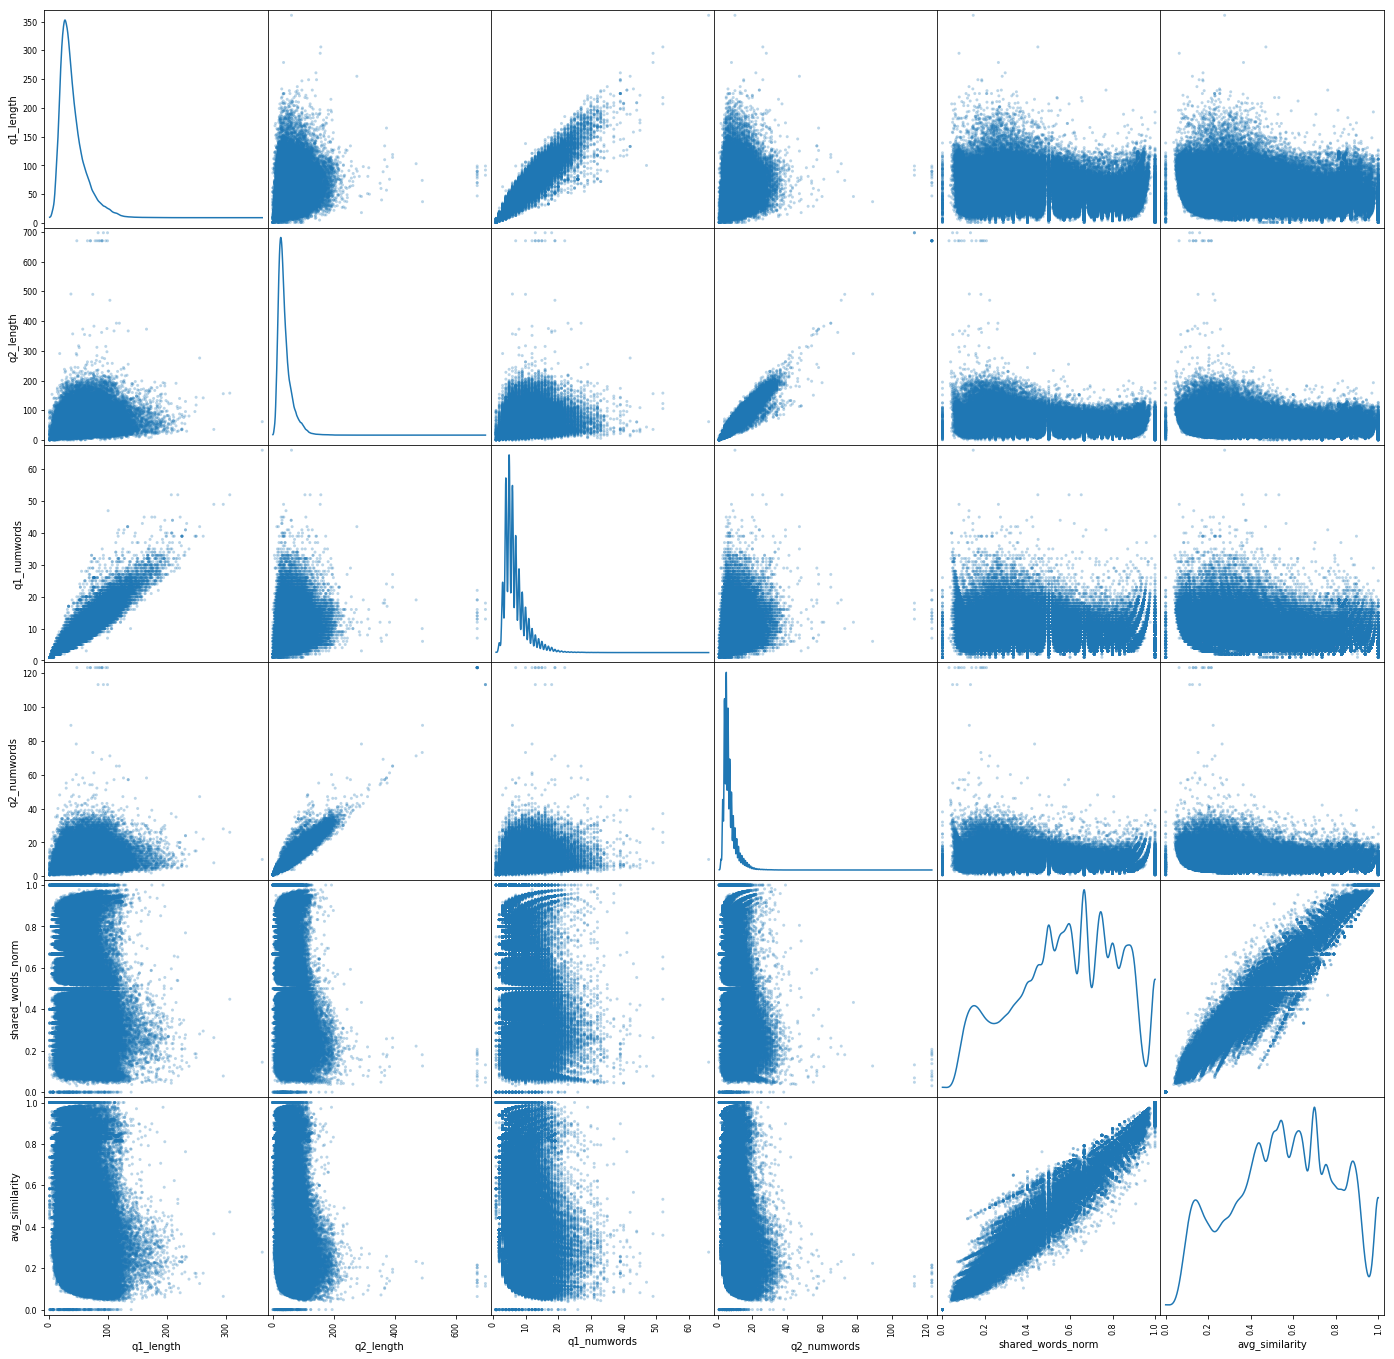

In [96]:
pd.plotting.scatter_matrix(feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
            'shared_words_norm', 'avg_similarity']], alpha = 0.3, figsize = (24,24), diagonal = 'kde');

We can observe average similarity is correlated well with the shared normalized words.

#### Normalize Features between 0 and 1

In [77]:
## Scale the featureset to same min max values as our word2vec data scores ranges between -0.25 to 0.25
min_range = round(np.min(test_mean_sentence_vector),2)
max_range = round(np.max(test_mean_sentence_vector),2)

scale = MinMaxScaler(feature_range = (min_range, max_range))
scale.fit(feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
                      'shared_words_norm', 'avg_similarity']])
Xfeature = scale.transform(feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
                                       'shared_words_norm', 'avg_similarity']])

print  "Scaled Feature Min Value: ", np.min(Xfeature)
print  "Scaled Feature Max Value: ", np.max(Xfeature)
print "Shape of Feature Matrix:" , Xfeature.shape

Scaled Feature Min Value:  -0.43
Scaled Feature Max Value:  0.43
Shape of Feature Matrix: (404290, 6)


#### Add vector based cosine distance as a feature

In [63]:
q1_vec = compute_sentence_vec(df_train_clean['question1'], w2v)
q2_vec = compute_sentence_vec(df_train_clean['question2'], w2v)

In [64]:
from sklearn.metrics import pairwise
cosine_sim = np.array([])
for i in range(q1_vec.shape[0]):
    dist = pairwise.cosine_similarity(np.expand_dims(q1_vec[i], axis=0), np.expand_dims(q2_vec[i],axis=0))
    cosine_sim = np.concatenate([cosine_sim, dist.reshape((-1))])

print cosine_sim.shape    
cosine_sim = np.expand_dims(cosine_sim, axis=1)

(404290,)


In [70]:
print "Shape of cosine similiarty", cosine_sim.shape
print "Shape of word2vec Feature Matrix:" , mean_sentence_vector.shape

Shape of cosine similiarty (404290, 1)
Shape of word2vec Feature Matrix: (404290, 100)


In [78]:
## Combine all feature vectors
combined_feature_vector = np.hstack((mean_sentence_vector, cosine_sim, Xfeature))
print "Shape of Combined Feature Matrix:" , combined_feature_vector.shape
print "Shape of Training labels", len(train_labels)

Shape of Combined Feature Matrix: (404290, 107)
Shape of Training labels 404290


## Section 4. Training Features 

* We experiment with a few classification methods

In [115]:
X_train, X_valid, y_train, y_valid = train_test_split(combined_feature_vector, train_labels, test_size=0.25, random_state=3)

In [116]:
## Logistic Regression
print "==================Logistic Regression Model============================================"
LR = LogisticRegression(C=1.0, penalty='l1')
LR.fit(X_train, y_train)
y_preds = LR.predict(X_valid)
print "Logistic Regression Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid)
print "Logistic Regression Model  F1 score:", metrics.classification_report(y_preds, y_valid)
print "Logistic Regression Model log loss:", metrics.log_loss(y_preds, y_valid)
print '\n'

print "==================Gaussian Naive Bayes============================================"
GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_preds = GNB.predict(X_valid)
print "Gaussian Naive Bayes Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid)
print "Gaussian Naive Bayes Model  F1 score:", metrics.classification_report(y_preds, y_valid)
print "Gaussian Naive Bayes Model log loss:", metrics.log_loss(y_preds, y_valid)
print '\n'

print "==================Support Vector Machines============================================"
sv = svm.SVC(C=1.0, kernel='linear')
sv.fit(X_train, y_train)
y_preds = sv.predict(X_valid)
print "Support Vector Machine Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid)
print "Support Vector Machine F1 score:", metrics.classification_report(y_preds, y_valid)
print "Support Vector Machine log loss:", metrics.log_loss(y_preds, y_valid)
print '\n'

print "==================RandomForestClassifier============================================"
RF = RandomForestClassifier(n_estimators=100, max_depth=10, criterion = 'entropy')
RF.fit(X_train, y_train)
y_preds = RF.predict(X_valid)
print "Random Forest Classifier Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid)
print "Random Forest Classifier F1 score:", metrics.classification_report(y_preds, y_valid)
print "Random Forest Classifier log loss:", metrics.log_loss(y_preds, y_valid)
print '\n'

==================Logistic Regression Model============================================
Logistic Regression Model predictive accuracy: 0.745057685077
Logistic Regression Model  F1 score:              precision    recall  f1-score   support

          0       0.83      0.78      0.80     67323
          1       0.61      0.67      0.64     33743

avg / total       0.75      0.75      0.75    101066

Logistic Regression Model log loss: 8.80551197307


==================Gaussian Naive Bayes============================================
Gaussian Naive Bayes Model predictive accuracy: 0.701719668336
Gaussian Naive Bayes Model  F1 score:              precision    recall  f1-score   support

          0       0.66      0.83      0.74     50691
          1       0.77      0.57      0.66     50375

avg / total       0.72      0.70      0.70    101066

Gaussian Naive Bayes Model log loss: 10.302305576


==================Support Vector Machines============================================
Support V

** Overall Random Forrest Gives the best performance using training and validation sets without hyper parameter tuning **

## Section 5. HyperParameter tuning

#### Tuning the hyperparameters for the model use the hpsklearn package which allows us to fit classifier models at the same time and also tune hyper parameters to get to the best model.

* hpsklearn also comes with any_classifier option which will run through all classifiers to find the one of the classifier

In [28]:
## Load the hpsklearn package
from hpsklearn import HyperoptEstimator, any_classifier, svc, random_forest, knn, ada_boost
from hyperopt import tpe
from hpsklearn.estimator import hyperopt_estimator

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


#### The total data is too large to run without computer clusters. For the purpose of the project, we will use a subset of samples for hyper tuning which can be run with 1 CPU

In [29]:
## Create test train split
X_train, X_test, y_train, y_test = train_test_split(combined_feature_vector, train_labels, test_size=0.25, random_state=3)

In [30]:
X_train_sub = X_train[0:5000]
y_train_sub = y_train[0:5000]
X_test_sub = X_test[0:5000]
y_test_sub = y_test[0:5000]

#### Hyperparameter optimization for best models selected from baseline model results with no parameter tuning: Random Forest

In [31]:
## Fit a HyperOpt estimator with random forest classifiers. This will use available classifiers
rfestim = HyperoptEstimator(classifier = random_forest('my_rf'))
rfestim.fit(X_train_sub, y_train_sub)

In [32]:
## print best model parameters
print(rfestim.best_model())

## print score of the best model on subset of the data
print( rfestim.score( X_test_sub, y_test_sub ) )

{'learner': RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1302, n_jobs=1, oob_score=False, random_state=1,
            verbose=False, warm_start=False), 'preprocs': (StandardScaler(copy=True, with_mean=True, with_std=True),), 'ex_preprocs': ()}
0.7616


In [33]:
rfbest = rfestim.best_model()

#### Retrain the full training set with selected RF setting

In [79]:
RF = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, 
                            max_features='log2', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                            min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, 
                            min_weight_fraction_leaf=0.0, n_estimators=1302, n_jobs=1, oob_score=False, 
                            random_state=1, verbose=False, warm_start=False)

In [80]:
X_train, y_train = combined_feature_vector, train_labels
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1302, n_jobs=1, oob_score=False, random_state=1,
            verbose=False, warm_start=False)


## Section 6: Prepare Test Dataset for Inference, Scoring, Submission

In [3]:
df_test_clean = pd.read_csv('test_df.csv').fillna("")
df_test_clean.head(5)

,test_id,question1,question2
0,0,surface pro 4 compare ipad pro ?,microsoft choose core m3 core i3 home surface ...
1,1,hair transplant age 24 ? much would cost ?,much cost hair transplant require ?
2,2,best way send money china us ?,send money china ?
3,3,food emulsifiers ?,foods fibre ?
4,4,aberystwyth start reading ?,start reading ?


In [5]:
## Prepare the test data set
# Combine the two question into 1 unified question set and create one combined question set.
df_test_clean['questions'] = df_test_clean['question1'] + " " + df_test_clean['question2']

In [6]:
df_test_clean.head(5)

,test_id,question1,question2,questions
0,0,surface pro 4 compare ipad pro ?,microsoft choose core m3 core i3 home surface ...,surface pro 4 compare ipad pro ? microsoft cho...
1,1,hair transplant age 24 ? much would cost ?,much cost hair transplant require ?,hair transplant age 24 ? much would cost ? muc...
2,2,best way send money china us ?,send money china ?,best way send money china us ? send money china ?
3,3,food emulsifiers ?,foods fibre ?,food emulsifiers ? foods fibre ?
4,4,aberystwyth start reading ?,start reading ?,aberystwyth start reading ? start reading ?


In [7]:
def sent_split(sentence):
    words = str(sentence).lower().split()
    return(words)

In [8]:
# Convert the questions into a list
test_qlist = df_test_clean['questions'].values
print test_qlist[0:5]

# Cleanse the questions using the function we created
test_qlist_token = [sent_split(qs) for qs in test_qlist]
print test_qlist_token[0:5]

[ 'surface pro 4 compare ipad pro ? microsoft choose core m3 core i3 home surface pro 4 ?'
 'hair transplant age 24 ? much would cost ? much cost hair transplant require ?'
 'best way send money china us ? send money china ?'
 'food emulsifiers ? foods fibre ?'
 'aberystwyth start reading ? start reading ?']
[['surface', 'pro', '4', 'compare', 'ipad', 'pro', '?', 'microsoft', 'choose', 'core', 'm3', 'core', 'i3', 'home', 'surface', 'pro', '4', '?'], ['hair', 'transplant', 'age', '24', '?', 'much', 'would', 'cost', '?', 'much', 'cost', 'hair', 'transplant', 'require', '?'], ['best', 'way', 'send', 'money', 'china', 'us', '?', 'send', 'money', 'china', '?'], ['food', 'emulsifiers', '?', 'foods', 'fibre', '?'], ['aberystwyth', 'start', 'reading', '?', 'start', 'reading', '?']]


In [15]:
## Word2Vec features for test dataset
test_mean_sentence_vector = compute_sentence_vec(test_qlist_token, w2v)
print "Length of Mean Sentence Vector ", len(test_mean_sentence_vector)

Length of Mean Sentence Vector  2345796


In [39]:
# If exist reload
if os.path.exists('test_feature_df.pkl'):
    test_feature_df = pd.read_pickle('test_feature_df.pkl')
else: # For traiing
    id_vals, question1, question2, duplicate, ochiai, jaccard, overlap, shared_words_norm = calculate_similarity_score_vectors(df_test_clean, test='Y')   
    q1_length, q2_length, q1_numwords, q2_numwords = quest_length(question1, question2)
    ## Build a pandas dataframe off the computed features
    test_feature_df = pd.DataFrame(
        {'id' : id_vals,
         'q1_length': q1_length,
         'question1': question1,
         'q2_length': q2_length,
         'question2' : question2,
         'q1_numwords': q1_numwords,
         'q2_numwords': q2_numwords,
         'ochiai': ochiai,
         'jaccard': jaccard,
         'overlap': overlap,
         'shared_words_norm' : shared_words_norm
        })
    print "Feature vector shape: ", test_feature_df.shape
    ## Save the train dataframe to pickle to save space
    pd.to_pickle(test_feature_df, 'test_feature_df.pkl')

Total Number of Questions Pairs:  2345796 2345796
Feature vector shape:  (2345796, 11)


In [41]:
test_feature_df['avg_similarity'] = (test_feature_df['jaccard'] + test_feature_df['overlap'] + test_feature_df['ochiai']) / 3.0
test_feature_df.drop(['jaccard', 'overlap', 'ochiai'], axis=1, inplace = True)

In [42]:
test_feature_df.head(5)

,id,q1_length,q1_numwords,q2_length,q2_numwords,question1,question2,shared_words_norm,avg_similarity
0,0,32,7,53,11,surface pro 4 compare ipad pro ?,microsoft choose core m3 core i3 home surface ...,0.500000,0.485281
1,1,42,9,35,6,hair transplant age 24 ? much would cost ?,much cost hair transplant require ?,0.733333,0.689768
2,2,30,7,18,4,best way send money china us ?,send money china ?,0.727273,0.775786
3,3,18,3,13,3,food emulsifiers ?,foods fibre ?,0.333333,0.288889
4,4,27,4,15,3,aberystwyth start reading ?,start reading ?,0.857143,0.872008


In [85]:
## Scale the featureset to same min max values as our word2vec data scores ranges between -0.25 to 0.25
min_range = round(np.min(test_mean_sentence_vector),2)
max_range = round(np.max(test_mean_sentence_vector),2)

scale = MinMaxScaler(feature_range = (min_range, max_range))
scale.fit(test_feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
                      'shared_words_norm', 'avg_similarity']])
test_Xfeature = scale.transform(test_feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
                                       'shared_words_norm', 'avg_similarity']])

print  "Scaled Feature Min Value: ", np.min(test_Xfeature)
print  "Scaled Feature Max Value: ", np.max(test_Xfeature)
print "Shape of Feature Matrix:" , test_Xfeature.shape

Scaled Feature Min Value:  -0.43
Scaled Feature Max Value:  0.43
Shape of Feature Matrix: (2345796, 6)


In [45]:
test_q1_vec = compute_sentence_vec(df_test_clean['question1'], w2v)
test_q2_vec = compute_sentence_vec(df_test_clean['question2'], w2v)

In [86]:
from sklearn.metrics import pairwise
cosine_sim = np.array([])
for i in range(test_q1_vec.shape[0]):
    dist = pairwise.cosine_similarity(np.expand_dims(test_q1_vec[i], axis=0), np.expand_dims(test_q2_vec[i],axis=0))
    cosine_sim = np.concatenate([cosine_sim, dist.reshape((-1))])

print cosine_sim.shape                             

(2345796,)


In [87]:
cosine_sim = np.expand_dims(cosine_sim, axis=1)
print "Shape of cosine similiarty", cosine_sim.shape
print "Shape of word2vec Feature Matrix:" , test_mean_sentence_vector.shape

Shape of cosine similiarty (2345796, 1)
Shape of word2vec Feature Matrix: (2345796, 100)


In [88]:
## Combine all feature vectors
combined_test_feature_vector = np.hstack((test_mean_sentence_vector, cosine_sim, test_Xfeature))
print "Shape of Combined Feature Matrix:" , combined_test_feature_vector.shape

Shape of Combined Feature Matrix: (2345796, 107)


### Test Predictions Using Random Forest

##### Random Forest Predictions on Test Data

In [89]:
## Random Forest test prediction 
rf_y_test_preds = RF.predict(combined_test_feature_vector)

kaggle_rf = pd.DataFrame({'test_id': test_feature_df['id'], 'is_duplicate': rf_y_test_preds})
kaggle_rf.head()
kaggle_rf.to_csv("kaggle_qyu_rf.csv", index=False)

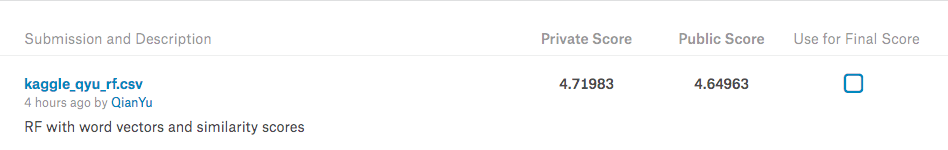

In [3]:
from IPython.display import Image
Image(filename='kaggle_submit.png')

### Summary

##### In this project, we tried to tackle the Quora question pair challenge. Our approach started with building a word to vector and paragraph vector representation of the pair of questions and then adding similarity and textual features to the mix.
##### We tried different modeling approaches including Logistic Regression, Naive Bayes, Random Forest. We experiment a few other features.
#### Key learning:
* Good language model representation does not translate to good features for classificaton
* Training and hyper-parameter takes a long time due to the large number of samples
* In pratice, ensamble method shows better performance

## Appendix

### POS Tagging and Contextual Functions
There are a few reasons that we decided not to use POS tagging in our model:  
    
1. Long run time: on average, it takes more than an 30 mins to calculate POS_tagging and contextual label on the training set. It takes more than an hour to apply on the test set.
2. Limited benefit to our model accuracy: we use POS tag and context information (previous word, next word) to enrich the questions, we remove less important tag, and compare similarity. However, the accuracy improvement is small 1-2% using a smaller development set. We think the reson is due to the fact that there are only a few words in each pair of questions we are trying to compare.

### The following section is not used in our model

In [ ]:
## Fuction to Tagging the question list
def pos_tagging(q1, q2):
    pos_tagging_q1 = []
    pos_tagging_q2 = []
    
    for i in range(len(q1)):
        q1_txt = nltk.word_tokenize(q1[i])
        q2_txt = nltk.word_tokenize(q2[i])
        pos_tagging_q1.append(nltk.pos_tag(q1_txt))
        pos_tagging_q2.append(nltk.pos_tag(q2_txt))

    return pos_tagging_q1, pos_tagging_q2

## Create a list of questions with tags
pos_tagging_Q1, pos_tagging_Q2 = pos_tagging(question_1, question_2)

## A list of unimportant tag to filter out
ignore_tag_list = ['CC', 'DT', 'EX', 'FW', 'IN', 'JJR', 'JJS', 'LS', 'PDT', 'POS', 
                   'RB', 'RBR', 'RBS', 'RP', 'S', 'SBAR', 'SBARQ', 'SYM', 'TO', '.', '))', '((']

## Filter tag with ignore_tag_list
def filter_tag(pos_q1, pos_q2):
    tag_q1 = []
    tag_q2 = []
    
    for i in range(len(pos_q1)):
        tag_q1.append([x for x in pos_q1[i] if (x[1] not in ignore_tag_list)])
        tag_q2.append([x for x in pos_q2[i] if (x[1] not in ignore_tag_list)])
    
    return tag_q1, tag_q2

tags_q1, tags_q2 = filter_tag(pos_tagging_Q1, pos_tagging_Q2)

## Another option is to combine tag and word in one string and use the list to compare similarity of 2 questions
def comb_tag(tags_q1, tags_q2):
    comb_q1 = []
    comb_q2 = []
    
    for i in range(len(tags_q1)):
        comb_q1.append([x[0]+x[1] for x in tags_q1[i]])
        comb_q2.append([x[0]+x[1] for x in tags_q2[i]])
    
    return comb_q1, comb_q2

comb_words_q1, comb_words_q2 = comb_tag(tags_q1, tags_q2)

# a helper function find and label neighboring words in a sentense with index
def pos_features(sentence, i):
    features = {}
    if len(sentence) == 1:
        features["prev-word"] = "<None>"
        features["next-word"] = "<None>"
    else:
        if i == 0:
            features["prev-word"] = "<START>"
            features["next-word"] = sentence[i+1]
        elif i == (len(sentence) - 1):
            features["prev-word"] = sentence[i-1]
            features["next-word"] = "<End>"
        else:
            features["prev-word"] = sentence[i-1]
            features["next-word"] = sentence[i+1]
    return features

## Generate contextual information in a list of dict
def context_a_sent(sent):
    context_list = []
    for i in range(len(sent)): 
        context_list.append(pos_features(sent, i))
    return context_list

## Generate contextual information in a list of list 
def context_tag(comb_q1):
    context_tags = []
    for i in range(len(comb_q1)):
        context_tag = []
        context = context_a_sent(comb_q1[i])
        
        for item in context:
            x = list(zip(item.keys(), item.values()))  
            context_tag.append(x[0][0] + x[0][1]+" "+x[1][0] + x[1][1])
        context_tags.append(context_tag)
    return context_tags

context_tags_q1 = context_tag(comb_words_q1)
context_tags_q2 = context_tag(comb_words_q2)